# 📊 IT Company Review Clustering Analysis: Production Pipeline
---

**Objective:**
- Perform advanced clustering analysis on Vietnamese IT company reviews using both "What I liked" and "Suggestions for improvement" columns.
- Deliver a clean, modular, and production-ready notebook for HR analytics and business insights.

**Workflow Outline:**
1. **Import Packages & Setup**
2. **Data Loading & Preprocessing** (Project1_Le advanced Vietnamese text processing)
3. **Exploratory Data Analysis (EDA)** (Charts, word clouds, text stats)
4. **Text Vectorization & Topic Modeling** (LDA, CountVectorizer/TF-IDF)
5. **Clustering Algorithms** (KMeans, Agglomerative, DBSCAN)
6. **Evaluation & Visualization** (Silhouette, PCA plots, cluster interpretation)
7. **Business Insights & Recommendations**
8. **Utility Functions** (Save/load, prediction, etc.)

# 1. Import Packages & Setup Environment

## impport packages

In [1]:
# Import all required packages and set up environment
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text processing
import re
import regex
import string
from collections import Counter
import nltk
from underthesea import word_tokenize, pos_tag, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Clustering & Topic Modeling
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE

from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm
# Evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Progress bar
from tqdm import tqdm

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
# plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

COLORS = ['#2E86C1', '#28B463', '#F39C12', '#E74C3C', '#8E44AD', '#17A2B8', '#FFC107', '#DC3545']

print("✅ All libraries imported and environment set up!")

✅ All libraries imported and environment set up!


## load data

In [ ]:
# Load review data from Excel (modular function)
def load_data():
    """Load review data from Excel file."""
    file_path = "/home/thinhdao/it_viec_project1/Du lieu cung cap/Reviews.xlsx"
    try:
        df = pd.read_excel(file_path)
        print(f"✅ Loaded data from {file_path}")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

df = load_data()

# Vietnamese Text Preprocessing 

- **Dictionary-based normalization**: Emoji, teencode, English-Vietnamese mapping
- **POS tagging với underthesea**: Chỉ giữ lại N, Np, A, AB, V, VB, VY, R
- **Special word processing**: Kết hợp từ có nghĩa
- **Stopwords removal**: Loại bỏ từ không có ý nghĩa
- **Emotion word counting**: Đếm từ tích cực/tiêu cực

In [ ]:
# Load dictionaries following Project1_Le approach
print("🔄 Loading dictionaries using Project1_Le approach...")

# Define files folder path - corrected path
files_folder = '/home/thinhdao/it_viec_project1/Du lieu cung cap/files'

#LOAD EMOJICON
emoji_path = os.path.join(files_folder, 'emojicon.txt')
emoji_dict = {}
try:
    with open(emoji_path, 'r', encoding="utf8") as file:
        emoji_lst = file.read().split('\n')
        for line in emoji_lst:
            if '\t' in line:
                key, value = line.split('\t')
                emoji_dict[key] = str(value)
    print(f"✅ Loaded {len(emoji_dict)} emoji mappings")
except:
    print("⚠️ Could not load emoji dictionary")
    emoji_dict = {}

#LOAD TEENCODE
teencode_path = os.path.join(files_folder, 'teencode.txt')
teen_dict = {}
try:
    with open(teencode_path, 'r', encoding="utf8") as file:
        teen_lst = file.read().split('\n')
        for line in teen_lst:
            if '\t' in line:
                key, value = line.split('\t')
                teen_dict[key] = str(value)
    print(f"✅ Loaded {len(teen_dict)} teencode mappings")
except:
    print("⚠️ Could not load teencode dictionary")
    teen_dict = {}

#LOAD TRANSLATE ENGLISH -> VNMESE
english_path = os.path.join(files_folder, 'english-vnmese.txt')
english_dict = {}
try:
    with open(english_path, 'r', encoding="utf8") as file:
        english_lst = file.read().split('\n')
        for line in english_lst:
            if '\t' in line:
                key, value = line.split('\t')
                english_dict[key] = str(value)
    print(f"✅ Loaded {len(english_dict)} English-Vietnamese mappings")
except:
    print("⚠️ Could not load English-Vietnamese dictionary")
    english_dict = {}

#LOAD wrong words
wrong_path = os.path.join(files_folder, 'wrong-word.txt')
wrong_lst = []
try:
    with open(wrong_path, 'r', encoding="utf8") as file:
        wrong_lst = file.read().split('\n')
    print(f"✅ Loaded {len(wrong_lst)} wrong words")
except:
    print("⚠️ Could not load wrong words")
    wrong_lst = []

#LOAD STOPWORDS
stopwords_path = os.path.join(files_folder, 'vietnamese-stopwords.txt')
stopwords_lst = []
try:
    with open(stopwords_path, 'r', encoding="utf8") as file:
        stopwords_lst = file.read().split('\n')
    print(f"✅ Loaded {len(stopwords_lst)} stopwords")
except:
    print("⚠️ Could not load stopwords")
    stopwords_lst = []

In [ ]:
# Project1_Le preprocessing functions
import regex
from underthesea import word_tokenize, pos_tag, sent_tokenize

def process_text(text, emoji_dict, teen_dict, wrong_lst, english_dict):
    """Process text using Project1_Le method"""
    document = text.lower()
    document = document.replace("'",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### CONVERT ENGLISH ***
        sentence = ' '.join(english_dict[word] if word in english_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

def normalize_repeated_characters(text):
    """Normalize repeated characters as in Project1_Le"""
    import re
    return re.sub(r'(.)\1+', r'\1', text)

def loaddicchar():
    """Load character dictionary for unicode normalization"""
    uniChars = "àáảãạâầấẩ|ẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựýỳỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴ|ẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨ|ỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split('|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

def covert_unicode(txt):
    """Convert unicode as in Project1_Le"""
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

def process_special_word(text):
    """Process special words as in Project1_Le"""
    special_words = ['không', 'chưa', 'không phải', 'không đủ', 'quá', 'thiếu', 'tệ',
                     "môi trường", "công ty", "đồng nghiệp", "quản lý", "sếp", "hỗ trợ",
                     "sáng tạo", "hài lòng", "tốt", "văn hóa", "phát triển", "học hỏi", "cơ hội",
                     "đào tạo", "thăng tiến", "tăng trưởng", "khả năng", "chuyên nghiệp", "đồng đội", "văn phòng",
                     "hợp tác", "áp lực", "khó khăn", "chất lượng", "kém", "không rõ ràng", "mâu thuẫn"]
    new_text = ''
    text_lst = text.split()
    i = 0

    while i < len(text_lst):
        word = text_lst[i]
        if word in special_words:
            next_idx = i + 1
            if next_idx < len(text_lst):
                word = word + '_' + text_lst[next_idx]
            i = next_idx + 1
        else:
            i += 1
        new_text = new_text + word + ' '

    return new_text.strip()

def process_postag_thesea(text):
    """Process POS tagging as in Project1_Le"""
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

def remove_stopword(text, stopwords):
    """Remove stopwords as in Project1_Le"""
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

print("✅  preprocessing functions loaded!")

In [ ]:
# Positive and negative word lists for emotion counting
positive_words = [
    "thích", "tốt", "xuất sắc", "tuyệt vời", "ổn","hài lòng", "ưng ý", "hoàn hảo", "chất lượng", "nhanh",
    "thân thiện", "rất tốt", "rất thích", "tận tâm", "đáng tin cậy", "đẳng cấp","an tâm", "thúc đẩy", "cảm động",
    "nổi trội","sáng tạo", "phù hợp", "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", "cẩn thận",
    "vui vẻ", "hào hứng", "đam mê", 'chuyên', 'dễ', 'giỏi', 'hay', 'hiệu', 'hài', 'hỗ trợ', 'nhiệt tình',
    'thân', 'tuyệt', 'vui', 'chuyên nghiệp', 'động lực', 'dễ chịu','công bằng', 'hạnh phúc', 'hợp lý','truyền cảm hứng',
    'phát triển', 'nổi bật','hợp tác', 'đồng đội', 'hòa đồng', 'học hỏi', 'tôn trọng', 'tốt nhất', 'vui mừng', 'đẳng cấp',
    'dễ dàng', 'chủ động', 'đồng cảm', 'cảm', 'mở rộng', 'bình đẳng', 'năng động', 'thoải mái', 'mến', 'cảm ơn', 'tốt hơn','cởi mở', 'cơ hội'
]

negative_words = [
    "kém", "tệ", "buồn", "không dễ chịu", "không thích", "không ổn", "áp lực", "mệt","không đáng tin cậy", "không chuyên nghiệp",
    "không thân thiện", "không tốt", "chậm", "khó khăn", "phức tạp",
    "khó chịu", "gây khó dễ", "rườm rà", "tồi tệ", "khó xử", "không thể chấp nhận", "không rõ ràng",
    "rối rắm", 'không hài lòng', 'quá tệ', 'rất tệ', "phiền phức",
    'thất vọng', 'tệ hại', 'kinh khủng', 'chán', 'drama', 'dramas', 'gáp', 'gắt',
    'lỗi', 'ngắt', 'quái', 'quát', 'thiếu', 'trễ', 'tệp', 'tồi', "hách dịch",
    'căng thẳng', 'không hòa đồng', 'thiếu đào tạo', 'thiếu sáng tạo',
    'khủng hoảng', 'rối loạn', 'không có cơ hội', 'thiếu công bằng', 'không chấp nhận được',
    'không đủ', 'thiếu sự công nhận', 'thiếu hỗ trợ', 'không hợp', 'thiếu cơ hội thăng tiến', 'áp', 'trì trệ', 'thất bại',
    'thiếu sự minh bạch', 'buồn bã', 'rối', 'không đáng', 'mâu thuẫn',
    'thiếu chuyên nghiệp', 'thiếu động lực', 'lo lắng', 'môi trường thiếu cởi mở', 'mệt mỏi','lo'
    'thiếu linh hoạt', 'không tôn trọng', 'tức giận', 'không phát triển', 'thiếu sự rõ ràng', 'bực bội'
]

# Extend positive and negative words with underscore versions
positive_words_extend = ['_'.join(word.split()) if len(word.split()) > 1 else word for word in positive_words]
positive_words.extend(positive_words_extend)

negative_words_extend = ['_'.join(word.split()) if len(word.split()) > 1 else word for word in negative_words]
negative_words.extend(negative_words_extend)

def find_words(document, list_of_words):
    """Count emotion words in document"""
    document_lower = document.lower()
    word_count = 0
    word_list = []

    for word in list_of_words:
        if word in document_lower:
            word_count += document_lower.count(word)
            word_list.append(word)

    return word_count, word_list

In [ ]:
# Unified VietnamesePreprocessor with English-to-Vietnamese translation support

from googletrans import Translator
import re
import time
from underthesea import sent_tokenize, word_tokenize, pos_tag

class VietnamesePreprocessor:
    """Unified Vietnamese preprocessor with Google Translate functionality"""
    
    def __init__(self, files_dir=''):
        # Initialize existing dictionaries from loaded variables
        self.emoji_dict = emoji_dict
        self.teen_dict = teen_dict
        self.wrong_lst = wrong_lst
        self.stopwords_lst = stopwords_lst
        self.english_dict = english_dict
        
        # Initialize Google Translator
        # self.translator = Translator()
        
        # Initialize sentiment words (comprehensive list)
        self.positive_words = set(positive_words + [
            "thích", "tốt", "xuất sắc", "tuyệt vời", "ổn", "hài lòng", "ưng ý", "hoàn hảo", 
            "chất lượng", "nhanh", "thân thiện", "rất tốt", "rất thích", "tận tâm", 
            "đáng tin cậy", "đẳng cấp", "an tâm", "thúc đẩy", "cảm động", "nổi trội", 
            "sáng tạo", "phù hợp", "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", 
            "cẩn thận", "vui vẻ", "hào hứng", "đam mê", "chuyên", "cảm", "dễ", "giỏi", 
            "hay", "hiệu", "hài", "hỗ trợ", "nhiệt tình", "vui", "chuyên nghiệp", 
            "động lực", "dễ chịu", "công bằng", "hạnh phúc", "hợp lý", "thân", 
            "truyền cảm hứng", "phát triển", "nổi bật", "hợp tác", "đồng đội", 
            "hòa đồng", "học hỏi", "tôn trọng", "tốt nhất", "vui mừng", "tuyệt", 
            "chủ động", "đồng cảm", "mở rộng", "bình đẳng", "năng động", "thoải mái", 
            "mến", "cảm ơn", "tốt hơn", "cởi mở", "cơ hội", "excellent", "good", "great",
            "amazing", "awesome", "fantastic", "wonderful", "perfect", "outstanding"
        ])
        
        self.negative_words = set(negative_words + [
            "kém", "tệ", "buồn", "chán", "không dễ chịu", "không thích", "không ổn", 
            "áp lực", "mệt", "không hợp", "không đáng tin cậy", "không chuyên nghiệp", 
            "không thân thiện", "không tốt", "chậm", "khó khăn", "phức tạp", "khó chịu", 
            "gây khó dễ", "rườm rà", "tồi tệ", "khó xử", "không thể chấp nhận", 
            "không rõ ràng", "rối rắm", "không hài lòng", "không đáng", "quá tệ", 
            "rất tệ", "phiền phức", "thất vọng", "tệ hại", "kinh khủng", "drama", 
            "dramas", "gáp", "gắt", "lỗi", "ngắt", "quái", "quát", "rối", "thiếu", 
            "trễ", "tệp", "tồi", "áp", "đáp", "hách dịch", "căng thẳng", "khủng hoảng", 
            "rối loạn", "không có cơ hội", "thiếu công bằng", "tồi", "không chấp nhận được", 
            "không đủ", "thiếu sự công nhận", "buồn bã", "mâu thuẫn", "thiếu chuyên nghiệp", 
            "thiếu động lực", "lo lắng", "môi trường thiếu cởi mở", "mệt mỏi", 
            "thiếu linh hoạt", "không phát triển", "thiếu sự rõ ràng", "bực bội", 
            "tức giận", "không tôn trọng", "bad", "terrible", "awful", "horrible", 
            "disappointing", "frustrating", "annoying", "stressful"
        ])
        
        # Add extended versions of multi-word expressions
        negative_words_extend = {'_'.join(word.split()) for word in self.negative_words if ' ' in word}
        self.negative_words.update(negative_words_extend)
        
        positive_words_extend = {'_'.join(word.split()) for word in self.positive_words if ' ' in word}
        self.positive_words.update(positive_words_extend)
        
        # print("🚀 Vietnamese Preprocessor initialized with Google Translate!")

    # def translate_english_to_vietnamese(self, text, max_retries=2):
    #     """Translate English text to Vietnamese using Google Translate"""
    #     try:
    #         # Split text into words
    #         words = text.split()
    #         translated_words = []
            
    #         for word in words:
    #             # Check if word is already in our English-Vietnamese dictionary
    #             if word.lower() in self.english_dict:
    #                 translated_words.append(self.english_dict[word.lower()])
    #                 continue
                
    #             # Check if word contains only English characters and is meaningful
    #             if re.match(r'^[a-zA-Z]+$', word) and len(word) > 2:
    #                 # Try to translate with Google Translate
    #                 for attempt in range(max_retries):
    #                     try:
    #                         translation = self.translator.translate(word, src='en', dest='vi')
    #                         if translation and translation.text:
    #                             # Clean the translation
    #                             translated_text = translation.text.lower().strip()
    #                             # Only use if it's actually different and reasonable
    #                             if translated_text != word.lower() and len(translated_text) > 0:
    #                                 translated_words.append(translated_text)
    #                             else:
    #                                 translated_words.append(word)
    #                             break
    #                         time.sleep(0.05)  # Small delay between requests
    #                     except Exception as e:
    #                         if attempt == max_retries - 1:
    #                             translated_words.append(word)  # Keep original if translation fails
    #                         time.sleep(0.1)
    #             else:
    #                 translated_words.append(word)
            
    #         return ' '.join(translated_words)
            
    #     except Exception as e:
    #         print(f"Translation error: {e}")
    #         return text  # Return original text if translation fails

    def preprocess_text(self, text):
        """Complete preprocessing pipeline with translation"""
        if not text or pd.isna(text):
            return ""
        
        # Step 1: Basic text cleaning
        text = str(text).lower()
        text = text.replace('công ty', '')
        text = text.replace("'",'')
        text = re.sub(r'\.+', ".", text)
        
        # Step 2: Translate English to Vietnamese
        # text = self.translate_english_to_vietnamese(text) # taking too long
        
        # Step 3: Process emojis and teen code
        text = process_text(text, self.emoji_dict, self.teen_dict, self.wrong_lst, self.english_dict)
        
        # Step 4: POS tagging with enhanced negation handling
        text = self.process_postag_thesea_enhanced(text)
        
        # Step 5: Remove stopwords
        text = remove_stopword(text, self.stopwords_lst)
        
        return text.strip()

    def process_postag_thesea_enhanced(self, text):
        """Enhanced POS tagging with improved negation handling"""
        if not text or pd.isna(text):
            return ""
            
        new_document_words = []
        
        try:
            for sentence in sent_tokenize(text):
                sentence = sentence.replace('.', '').strip()
                if not sentence:
                    continue

                try:
                    # Word segmentation
                    segmented_sentence = word_tokenize(sentence, format="text")
                    segmented_sentence = process_special_word(segmented_sentence)
                    # POS tagging
                    tagged_words = pos_tag(segmented_sentence)
                except Exception as e:
                    continue

                # Enhanced negation processing
                processed_words = []
                i = 0
                while i < len(tagged_words):
                    word, tag = tagged_words[i]
                    
                    # Handle negation patterns
                    if word == 'không':
                        # Try 3-word phrases first
                        if i + 2 < len(tagged_words):
                            next_word_1, next_word_2 = tagged_words[i+1][0], tagged_words[i+2][0]
                            phrase_3 = f"không_{next_word_1}_{next_word_2}"
                            if phrase_3 in self.negative_words:
                                processed_words.append((phrase_3, 'A'))
                                i += 3
                                continue
                        
                        # Try 2-word phrases
                        if i + 1 < len(tagged_words):
                            next_word_1 = tagged_words[i+1][0]
                            phrase_2 = f"không_{next_word_1}"
                            if phrase_2 in self.negative_words:
                                processed_words.append((phrase_2, 'A'))
                                i += 2
                                continue
                    
                    processed_words.append((word, tag))
                    i += 1

                # Filter by POS tags (keep meaningful word types)
                lst_word_type = ['N', 'NP', 'NC', 'NY', 'A', 'AB', 'AJ', 'V', 'VB', 'VY', 'R']
                final_words = [word for word, tag in processed_words if tag.upper() in lst_word_type]
                new_document_words.extend(final_words)
                
        except Exception as e:
            # Fallback: use the original process_postag_thesea function
            return process_postag_thesea(text)

        return ' '.join(new_document_words)

    @staticmethod
    def find_words(document, list_of_words):
        """Find sentiment words in document"""
        if not document:
            return 0, []
        document_lower = document.lower()
        word_count = 0
        word_list = []
        for word in list_of_words:
            if word in document_lower:
                word_count += document_lower.count(word)
                word_list.append(word)
        return word_count, word_list

# Replace the existing preprocessor with the enhanced version
preprocessor = VietnamesePreprocessor()
print("✅ Vietnamese Preprocessor ready!")

In [ ]:
# Create a sample of 1000 rows for demo and preprocess both columns
df_sample = df.copy()
df_sample['processed_liked'] = df_sample['What I liked'].apply(preprocessor.preprocess_text)
df_sample['processed_suggestions'] = df_sample['Suggestions for improvement'].apply(preprocessor.preprocess_text)
print("✅ Preprocessing complete for the sample data.")
df_sample[['Company Name', 'What I liked', 'processed_liked', 'Suggestions for improvement', 'processed_suggestions']]

# save df for later use
df_sample.to_csv("df_sample_processed.csv", index=False)

# 3. Exploratory Data Analysis (EDA) & Word Clouds on Sample

- Analyze text length, word frequency, and visualize word clouds for both columns on the sample.
- This step helps validate preprocessing and gives a quick business overview before full-scale modeling.

In [ ]:
# EDA: Text length and word frequency for both columns in the sample
for col in ['processed_liked', 'processed_suggestions']:
    print(f"\n--- {col} ---")
    lengths = df_sample[col].str.split().str.len()
    print(f"Mean length: {lengths.mean():.1f} words | Min: {lengths.min()} | Max: {lengths.max()}")
    all_words = ' '.join(df_sample[col]).split()
    from collections import Counter
    word_freq = Counter(all_words)
    print(f"Top 10 words: {word_freq.most_common(10)}")

In [ ]:
def comprehensive_dataset_overview(df):
    """
    Tạo báo cáo tổng quan toàn diện về dataset
    
    Args:
        df (pd.DataFrame): DataFrame cần phân tích
    """
    print("="*60)
    print("           PHÂN TÍCH TỔNG QUAN DATASET")
    print("="*60)
    
    # 1. Thông tin cơ bản
    print("\n🔍 1. THÔNG TIN CƠ BẢN:")
    print(f"   • Kích thước: {df.shape[0]:,} dòng × {df.shape[1]} cột")
    print(f"   • Dung lượng: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   • Số ô dữ liệu: {df.size:,}")
    
    # 2. Thông tin về cột
    print(f"\n📊 2. THÔNG TIN VỀ CÁC CỘT:")
    data_info = pd.DataFrame({
        'Cột': df.columns,
        'Kiểu dữ liệu': df.dtypes,
        'Không null': df.count(),
        'Null values': df.isnull().sum(),
        'Tỷ lệ null (%)': (df.isnull().sum() / len(df) * 100).round(2),
        'Unique values': [df[col].nunique() for col in df.columns]
    })
    display(data_info)
    
    # 3. Missing values visualization
    if df.isnull().sum().sum() > 0:
        print("\n📈 3. VISUALIZATION MISSING VALUES:")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Missing values heatmap
        sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', ax=ax1)
        ax1.set_title('Heatmap Missing Values', fontsize=14, pad=20)
        
        # Missing values bar chart
        missing_data = df.isnull().sum()
        missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
        
        if len(missing_data) > 0:
            missing_data.plot(kind='bar', ax=ax2, color='coral')
            ax2.set_title('So luong Missing Values theo cot', fontsize=14, pad=20)
            ax2.set_ylabel('So luong missing')
            ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\n✅ 3. KHÔNG CÓ MISSING VALUES TRONG DATASET")
    
    # 4. Duplicate analysis
    duplicates = df.duplicated().sum()
    print(f"\n🔄 4. PHÂN TÍCH DUPLICATE:")
    print(f"   • Số dòng duplicate: {duplicates:,}")
    print(f"   • Tỷ lệ duplicate: {duplicates/len(df)*100:.2f}%")
    
    # 5. Text columns analysis  
    text_columns = ['What I liked', 'Suggestions for improvement']
    print(f"\n📝 5. PHÂN TÍCH CÁC CỘT TEXT:")
    
    for col in text_columns:
        if col in df.columns:
            null_count = df[col].isnull().sum()
            non_null_count = df[col].count()
            avg_length = df[col].dropna().str.len().mean()
            
            print(f"   📄 {col}:")
            print(f"      - Số reviews có nội dung: {non_null_count:,}")
            print(f"      - Số reviews trống: {null_count:,}")
            print(f"      - Độ dài trung bình: {avg_length:.1f} ký tự")
    
    print("\n" + "="*60)

# Thực hiện phân tích tổng quan
if df is not None:
    comprehensive_dataset_overview(df)

In [ ]:
def analyze_ratings(df):
    """
    Phân tích toàn diện về rating với visualizations đẹp
    
    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu
    """
    print("="*60)
    print("           PHÂN TÍCH RATING TOÀN DIỆN")
    print("="*60)
    
    # Kiểm tra cột rating
    rating_col = None
    for col in ['Rating', 'rating', 'Rate', 'rate']:
        if col in df.columns:
            rating_col = col
            break
    
    if rating_col is None:
        print("❌ Không tìm thấy cột rating trong dataset")
        return
    
    # Thống kê mô tả
    print(f"\n📊 1. THỐNG KÊ MÔ TẢ CHO CỘT '{rating_col}':")
    rating_stats = df[rating_col].describe()
    print(rating_stats)
    
    # Tạo visualizations
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Rating Distribution Histogram
    plt.subplot(3, 3, 1)
    plt.hist(df[rating_col].dropna(), bins=20, color='skyblue', alpha=0.8, edgecolor='black')
    plt.title('Phan bo diem danh gia', fontsize=14, pad=15)
    plt.xlabel('Diem danh gia')
    plt.ylabel('So luong')
    plt.grid(axis='y', alpha=0.3)
    
    # 2. Rating Box Plot
    plt.subplot(3, 3, 2)
    plt.boxplot(df[rating_col].dropna(), patch_artist=True, 
                boxprops=dict(facecolor='lightcoral', alpha=0.7))
    plt.title('Box Plot Diem Danh Gia', fontsize=14, pad=15)
    plt.ylabel('Diem danh gia')
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Rating by Count
    plt.subplot(3, 3, 3)
    rating_counts = df[rating_col].value_counts().sort_index()
    plt.bar(rating_counts.index, rating_counts.values, color='green', alpha=0.7)
    plt.title('So luong danh gia theo diem', fontsize=14, pad=15)
    plt.xlabel('Diem danh gia')
    plt.ylabel('So luong')
    plt.grid(axis='y', alpha=0.3)
    
    # 4. Rating Distribution Pie Chart
    plt.subplot(3, 3, 4)
    # Nhóm rating thành categories
    rating_categories = pd.cut(df[rating_col].dropna(), 
                              bins=[0, 2, 3, 4, 5], 
                              labels=['Kem (1-2)', 'Trung binh (2-3)', 'Tot (3-4)', 'Xuat sac (4-5)'])
    category_counts = rating_categories.value_counts()
    
    plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
            colors=['#ff9999', '#ffcc99', '#99ccff', '#99ff99'])
    plt.title('Phan bo theo nhom diem', fontsize=14, pad=15)
    
    # 5. Cumulative Distribution
    plt.subplot(3, 3, 5)
    sorted_ratings = np.sort(df[rating_col].dropna())
    y = np.arange(1, len(sorted_ratings) + 1) / len(sorted_ratings)
    plt.plot(sorted_ratings, y, color='purple', linewidth=2)
    plt.title('Phan phoi tich luy diem danh gia', fontsize=14, pad=15)
    plt.xlabel('Diem danh gia')
    plt.ylabel('Phan phoi tich luy')
    plt.grid(alpha=0.3)
    
    # 6. Rating Density Plot
    plt.subplot(3, 3, 6)
    df[rating_col].dropna().plot(kind='density', color='orange', linewidth=2)
    plt.title('Density Plot Diem Danh Gia', fontsize=14, pad=15)
    plt.xlabel('Diem danh gia')
    plt.ylabel('Mat do')
    plt.grid(alpha=0.3)
    
    # 7. Rating Statistics Text
    plt.subplot(3, 3, 7)
    plt.axis('off')
    stats_text = f"""
    THỐNG KÊ CHI TIẾT:
    
    Trung bình: {df[rating_col].mean():.2f}
    Trung vị: {df[rating_col].median():.2f}
    Mode: {df[rating_col].mode().iloc[0] if len(df[rating_col].mode()) > 0 else 'N/A'}
    Độ lệch chuẩn: {df[rating_col].std():.2f}
    
    Min: {df[rating_col].min():.1f}
    Max: {df[rating_col].max():.1f}
    
    Q1: {df[rating_col].quantile(0.25):.2f}
    Q3: {df[rating_col].quantile(0.75):.2f}
    IQR: {df[rating_col].quantile(0.75) - df[rating_col].quantile(0.25):.2f}
    
    Skewness: {df[rating_col].skew():.3f}
    Kurtosis: {df[rating_col].kurtosis():.3f}
    """
    plt.text(0.1, 0.9, stats_text, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    
    # 8. Rating Trend (if index represents time)
    plt.subplot(3, 3, 8)
    # Rolling average of ratings
    rolling_avg = df[rating_col].rolling(window=100, min_periods=1).mean()
    plt.plot(rolling_avg.index, rolling_avg.values, color='red', linewidth=2)
    plt.title('Xu huong diem danh gia theo thoi gian', fontsize=14, pad=15)
    plt.xlabel('Thu tu review')
    plt.ylabel('Diem trung binh')
    plt.grid(alpha=0.3)
    
    # 9. Rating vs Review Length (if applicable)
    plt.subplot(3, 3, 9)
    # Tính độ dài review tổng
    if 'What I liked' in df.columns and 'Suggestions for improvement' in df.columns:
        df['total_review_length'] = (df['What I liked'].fillna('').str.len() + 
                                   df['Suggestions for improvement'].fillna('').str.len())
        
        # Scatter plot với sample để tránh overcrowding
        sample_size = min(1000, len(df))
        sample_df = df.sample(n=sample_size, random_state=42)
        
        plt.scatter(sample_df['total_review_length'], sample_df[rating_col], 
                   alpha=0.6, color='green', s=20)
        plt.title('Moi quan he giua do dai review va diem', fontsize=14, pad=15)
        plt.xlabel('Do dai review')
        plt.ylabel('Diem danh gia')
        plt.grid(alpha=0.3)
    else:
        plt.axis('off')
        plt.text(0.5, 0.5, 'Không có dữ liệu\ntext để phân tích', 
                ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # In ra insights
    print(f"\n📈 2. INSIGHTS VỀ RATING:")
    print(f"   • Điểm trung bình: {df[rating_col].mean():.2f}/5")
    print(f"   • Điểm phổ biến nhất: {df[rating_col].mode().iloc[0] if len(df[rating_col].mode()) > 0 else 'N/A'}")
    print(f"   • Độ phân tán: {df[rating_col].std():.2f}")
    
    # Phân loại rating
    excellent = (df[rating_col] >= 4).sum()
    good = ((df[rating_col] >= 3) & (df[rating_col] < 4)).sum() 
    average = ((df[rating_col] >= 2) & (df[rating_col] < 3)).sum()
    poor = (df[rating_col] < 2).sum()
    
    print(f"   • Đánh giá xuất sắc (4-5): {excellent:,} ({excellent/len(df)*100:.1f}%)")
    print(f"   • Đánh giá tốt (3-4): {good:,} ({good/len(df)*100:.1f}%)")
    print(f"   • Đánh giá trung bình (2-3): {average:,} ({average/len(df)*100:.1f}%)")
    print(f"   • Đánh giá kém (<2): {poor:,} ({poor/len(df)*100:.1f}%)")
    
    print("\n" + "="*60)

# Thực hiện phân tích rating
if df is not None:
    analyze_ratings(df)

In [ ]:
def comprehensive_text_analysis(df):
    """
    Phân tích toàn diện cho 2 cột text: "What I liked" và "Suggestions for improvement"
    
    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu
    """
    print("="*70)
    print("           PHÂN TÍCH VĂN BẢN TOÀN DIỆN")
    print("="*70)
    
    # Định nghĩa 2 cột text chính
    text_columns = ['What I liked', 'Suggestions for improvement']
    
    # Kiểm tra sự tồn tại của các cột
    available_columns = [col for col in text_columns if col in df.columns]
    
    if not available_columns:
        print("❌ Không tìm thấy các cột text cần thiết")
        return None
    
    print(f"📊 Phân tích cho {len(available_columns)} cột text: {available_columns}")
    
    # Tạo DataFrame tổng hợp thống kê
    text_stats = pd.DataFrame()
    
    for col in available_columns:
        # Làm sạch dữ liệu
        clean_text = df[col].dropna().astype(str)
        
        # Thống kê cơ bản
        stats = {
            'Cột': col,
            'Tổng số dòng': len(df),
            'Có nội dung': len(clean_text),
            'Trống/Null': df[col].isnull().sum(),
            'Tỷ lệ có nội dung (%)': len(clean_text) / len(df) * 100,
            'Độ dài TB (ký tự)': clean_text.str.len().mean(),
            'Độ dài TB (từ)': clean_text.str.split().str.len().mean(),
            'Độ dài min': clean_text.str.len().min(),
            'Độ dài max': clean_text.str.len().max(),
            'Độ lệch chuẩn': clean_text.str.len().std()
        }
        
        text_stats = pd.concat([text_stats, pd.DataFrame([stats])], ignore_index=True)
    
    print(f"\n📈 1. THỐNG KÊ TỔNG QUAN:")
    display(text_stats.round(2))
    
    # Tạo comprehensive visualizations
    fig = plt.figure(figsize=(25, 20))
    plot_idx = 1
    
    for i, col in enumerate(available_columns):
        clean_text = df[col].dropna().astype(str)
        text_lengths_chars = clean_text.str.len()
        text_lengths_words = clean_text.str.split().str.len()
        
        # 1. Text length distribution (characters)
        plt.subplot(4, 4, plot_idx)
        plt.hist(text_lengths_chars, bins=50, alpha=0.7, color=COLORS[i], edgecolor='black')
        plt.title(f'Phan bo do dai text - {col[:20]}...', fontsize=12, pad=10)
        plt.xlabel('So ky tu')
        plt.ylabel('So luong')
        plt.grid(axis='y', alpha=0.3)
        plot_idx += 1
        
        # 2. Text length distribution (words)
        plt.subplot(4, 4, plot_idx)
        plt.hist(text_lengths_words, bins=30, alpha=0.7, color=COLORS[i+1], edgecolor='black')
        plt.title(f'Phan bo so tu - {col[:20]}...', fontsize=12, pad=10)
        plt.xlabel('So tu')
        plt.ylabel('So luong')
        plt.grid(axis='y', alpha=0.3)
        plot_idx += 1
        
        # 3. Box plot for text lengths
        plt.subplot(4, 4, plot_idx)
        data_to_plot = [text_lengths_chars, text_lengths_words]
        box_plot = plt.boxplot(data_to_plot, labels=['Ky tu', 'Tu'], patch_artist=True)
        colors_box = [COLORS[i], COLORS[i+1]]
        for patch, color in zip(box_plot['boxes'], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        plt.title(f'Box plot do dai - {col[:20]}...', fontsize=12, pad=10)
        plt.ylabel('So luong')
        plt.grid(axis='y', alpha=0.3)
        plot_idx += 1
        
        # 4. Text statistics summary
        plt.subplot(4, 4, plot_idx)
        plt.axis('off')
        stats_text = f"""
        THỐNG KÊ {col.upper()[:20]}:
        
        Số lượng: {len(clean_text):,}
        
        Độ dài (ký tự):
        • TB: {text_lengths_chars.mean():.1f}
        • Min: {text_lengths_chars.min()}
        • Max: {text_lengths_chars.max()}
        • Std: {text_lengths_chars.std():.1f}
        
        Độ dài (từ):
        • TB: {text_lengths_words.mean():.1f}
        • Min: {text_lengths_words.min()}
        • Max: {text_lengths_words.max()}
        • Std: {text_lengths_words.std():.1f}
        """
        
        plt.text(0.1, 0.9, stats_text, fontsize=10, va='top', ha='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=COLORS[i], alpha=0.3))
        plot_idx += 1
    
    # 5. Comparison between two columns (if both available)
    if len(available_columns) == 2:
        col1, col2 = available_columns
        clean_text1 = df[col1].dropna().astype(str)
        clean_text2 = df[col2].dropna().astype(str)
        
        # Length comparison
        plt.subplot(4, 4, plot_idx)
        lengths1 = clean_text1.str.len()
        lengths2 = clean_text2.str.len()
        
        plt.scatter(lengths1, lengths2, alpha=0.5, color='purple', s=20)
        plt.title('So sanh do dai giua 2 cot', fontsize=12, pad=10)
        plt.xlabel(f'Do dai {col1[:15]}...')
        plt.ylabel(f'Do dai {col2[:15]}...')
        plt.grid(alpha=0.3)
        plot_idx += 1
        
        # Add correlation
        correlation = lengths1.corr(lengths2)
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=plt.gca().transAxes, fontsize=10,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
        plot_idx += 1
        
        # Combined histogram
        plt.subplot(4, 4, plot_idx)
        plt.hist([lengths1, lengths2], bins=30, alpha=0.7, 
                label=[col1[:15] + '...', col2[:15] + '...'],
                color=[COLORS[0], COLORS[1]])
        plt.title('So sanh phan bo do dai', fontsize=12, pad=10)
        plt.xlabel('Do dai (ky tu)')
        plt.ylabel('So luong')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plot_idx += 1
        
        # Word count comparison
        plt.subplot(4, 4, plot_idx)
        words1 = clean_text1.str.split().str.len()
        words2 = clean_text2.str.split().str.len()
        
        plt.boxplot([words1, words2], labels=[col1[:10] + '...', col2[:10] + '...'],
                   patch_artist=True)
        plt.title('So sanh so tu giua 2 cot', fontsize=12, pad=10)
        plt.ylabel('So tu')
        plt.grid(axis='y', alpha=0.3)
        plot_idx += 1
        
        # Summary comparison
        plt.subplot(4, 4, plot_idx)
        plt.axis('off')
        comparison_text = f"""
        SO SÁNH 2 CỘT:
        
        {col1[:15]}...:
        • TB ký tự: {lengths1.mean():.1f}
        • TB từ: {words1.mean():.1f}
        
        {col2[:15]}...:
        • TB ký tự: {lengths2.mean():.1f}
        • TB từ: {words2.mean():.1f}
        
        Correlation: {correlation:.3f}
        
        Insights:
        • {'Liked dài hơn' if lengths1.mean() > lengths2.mean() else 'Suggestions dài hơn'}
        • {'Tương quan dương' if correlation > 0.3 else 'Tương quan yếu'}
        """
        
        plt.text(0.1, 0.9, comparison_text, fontsize=10, va='top', ha='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
        plot_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    # Word frequency analysis
    print(f"\n📊 2. PHÂN TÍCH TẦN SUẤT TỪ:")
    
    for col in available_columns:
        print(f"\n   🔤 Cột: {col}")
        clean_text = df[col].dropna().astype(str)
        
        # Combine all text
        all_text = ' '.join(clean_text.values).lower()
        
        # Simple tokenization (split by space)
        words = all_text.split()
        
        # Remove short words and numbers
        words = [word for word in words if len(word) > 2 and not word.isdigit()]
        
        # Count words
        word_freq = Counter(words)
        top_words = word_freq.most_common(15)
        
        print(f"      • Tổng từ: {len(words):,}")
        print(f"      • Từ duy nhất: {len(set(words)):,}")
        print(f"      • Top 15 từ phổ biến:")
        
        for idx, (word, count) in enumerate(top_words, 1):
            print(f"        {idx:2d}. {word:<15} ({count:,} lần)")
    
    print(f"\n📈 3. INSIGHTS VỀ VĂN BẢN:")
    
    if len(available_columns) == 2:
        col1, col2 = available_columns
        clean_text1 = df[col1].dropna().astype(str)
        clean_text2 = df[col2].dropna().astype(str)
        
        avg_len1 = clean_text1.str.len().mean()
        avg_len2 = clean_text2.str.len().mean()
        
        print(f"   • Cột '{col1}' có độ dài trung bình: {avg_len1:.1f} ký tự")
        print(f"   • Cột '{col2}' có độ dài trung bình: {avg_len2:.1f} ký tự")
        print(f"   • {'Feedback tích cực' if avg_len1 > avg_len2 else 'Gợi ý cải thiện'} có xu hướng dài hơn")
        
        # Coverage analysis
        both_filled = df[col1].notna() & df[col2].notna()
        only_col1 = df[col1].notna() & df[col2].isna()
        only_col2 = df[col1].isna() & df[col2].notna()
        
        print(f"   • Cả 2 cột có nội dung: {both_filled.sum():,} ({both_filled.sum()/len(df)*100:.1f}%)")
        print(f"   • Chỉ có '{col1}': {only_col1.sum():,} ({only_col1.sum()/len(df)*100:.1f}%)")
        print(f"   • Chỉ có '{col2}': {only_col2.sum():,} ({only_col2.sum()/len(df)*100:.1f}%)")
    
    print("\n" + "="*70)
    
    return text_stats

# Sử dụng dữ liệu đã load từ cell trước
# df đã có sẵn từ Reviews.xlsx

# Kiểm tra các cột cần thiết cho preprocessing
required_columns = ['What I liked', 'Suggestions for improvement']
print("Checking required columns...")
for col in required_columns:
    if col in df.columns:
        print(f"✅ Column '{col}' found with {df[col].notna().sum()} non-null values")
    else:
        print(f"❌ Column '{col}' NOT found")

print(f"\nDataset shape: {df.shape}")
print(f"Available columns: {list(df.columns)}")

# Tạo bản sao để xử lý
df_work = df.copy()
print(f"\nWorking dataframe created with shape: {df_work.shape}")

In [ ]:
def create_beautiful_wordclouds(df):
    """
    Tạo word clouds đẹp và chuyên nghiệp cho cả 2 cột text đã được xử lý
    
    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu với text đã được tiền xử lý
    """
    print("="*60)
    print("           TẠO WORD CLOUDS CHO 2 CỘT TEXT")
    print("="*60)
    
    text_columns = ['processed_liked', 'processed_suggestions']
    
    available_columns = [col for col in text_columns if col in df.columns]
    
    if not available_columns:
        print("❌ Không tìm thấy các cột text cần thiết")
        return
    
    # Tạo figure với subplots
    n_cols = len(available_columns)
    fig, axes = plt.subplots(2, n_cols, figsize=(12*n_cols, 16))
    
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, col in enumerate(available_columns):
        print(f"\n🔤 Đang tạo word cloud cho: {col}")
        
        # Lấy text đã được xử lý (không cần làm sạch thêm)
        clean_text = df[col].dropna().astype(str)
        
        # Combine all text
        combined_text = ' '.join(clean_text.values)
        
        if not combined_text.strip():
            print(f"⚠️  Không có từ khóa hợp lệ cho cột {col}")
            continue
        
        # Word frequency for analysis
        words = combined_text.split()
        word_freq = Counter(words)
        top_words = word_freq.most_common(20)
        
        # Create word cloud
        try:
            wordcloud = WordCloud(
                width=1200, 
                height=600,
                background_color='white',
                max_words=100,
                colormap='viridis',
                relative_scaling=0.5,
                min_font_size=12,
                max_font_size=80,
                collocations=False,
                prefer_horizontal=0.7
            ).generate(combined_text)
            
            # Plot word cloud
            axes[0, i].imshow(wordcloud, interpolation='bilinear')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Word Cloud - {col}', fontsize=16, pad=20, fontweight='bold')
            
        except Exception as e:
            print(f"❌ Lỗi tạo word cloud cho {col}: {str(e)}")
            axes[0, i].text(0.5, 0.5, f'Lỗi tạo word cloud\n{str(e)}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
        
        # Create bar chart for top words
        if top_words:
            words_list = [word for word, _ in top_words]
            counts_list = [count for _, count in top_words]
            
            # Create color palette
            colors = plt.cm.viridis(np.linspace(0, 1, len(words_list)))
            
            bars = axes[1, i].barh(range(len(words_list)), counts_list, color=colors)
            
            axes[1, i].set_yticks(range(len(words_list)))
            axes[1, i].set_yticklabels(words_list, fontsize=10)
            axes[1, i].set_xlabel('Tan suat xuat hien', fontsize=12)
            axes[1, i].set_title(f'Top 20 tu pho bien - {col}', fontsize=14, pad=15, fontweight='bold')
            axes[1, i].invert_yaxis()
            axes[1, i].grid(axis='x', alpha=0.3)
            
            # Add value labels on bars
            for bar, count in zip(bars, counts_list):
                width = bar.get_width()
                axes[1, i].text(width + max(counts_list)*0.01, bar.get_y() + bar.get_height()/2,
                               f'{count}', ha='left', va='center', fontsize=9)
        
        # Print top words
        print(f"   📊 Top 15 từ phổ biến:")
        for idx, (word, count) in enumerate(top_words[:15], 1):
            print(f"      {idx:2d}. {word:<15} ({count:,} lần)")
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: N-gram analysis
    print(f"\n📈 PHÂN TÍCH N-GRAM:")
    
    for col in available_columns:
        print(f"\n   🔤 Cột: {col}")
        clean_text = df[col].dropna().astype(str)
        
        # Combine text (đã được xử lý)
        combined_text = ' '.join(clean_text.values)
        words = combined_text.split()
        
        # Bigrams
        bigrams = [(words[i], words[i+1]) for i in range(len(words)-1)]
        bigram_freq = Counter(bigrams)
        top_bigrams = bigram_freq.most_common(10)
        
        print(f"      📌 Top 10 Bigrams:")
        for idx, (bigram, count) in enumerate(top_bigrams, 1):
            print(f"         {idx:2d}. '{bigram[0]} {bigram[1]}'  ({count} lần)")
        
        # Trigrams
        trigrams = [(words[i], words[i+1], words[i+2]) for i in range(len(words)-2)]
        trigram_freq = Counter(trigrams)
        top_trigrams = trigram_freq.most_common(5)
        
        print(f"      📌 Top 5 Trigrams:")
        for idx, (trigram, count) in enumerate(top_trigrams, 1):
            print(f"         {idx}. '{trigram[0]} {trigram[1]} {trigram[2]}'  ({count} lần)")
    
    print("\n" + "="*60)

# Tạo word clouds
if df is not None:
    create_beautiful_wordclouds(df_sample)


In [ ]:
# Word cloud visualization for both processed columns in the sample
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, col in enumerate(['processed_liked', 'processed_suggestions']):
    text = ' '.join(df_sample[col])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud: {col}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Clustering Modeling 

## 1. Simple Sample

In [35]:
# Vectorization and LDA topic modeling for both columns in the sample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def vectorize_and_lda(texts, n_topics=2):
    """
    Perform vectorization and LDA topic modeling
    Handle NaN values by filtering them out
    """
    # Filter out NaN values and convert to string
    clean_texts = texts.dropna().astype(str).tolist()
    
    if len(clean_texts) == 0:
        print("⚠️  No valid texts found after removing NaN values")
        return None, []
    
    print(f"📊 Processing {len(clean_texts)} valid texts (filtered from {len(texts)} total)")
    
    vectorizer = CountVectorizer(max_features=30, ngram_range=(1,2))
    X = vectorizer.fit_transform(clean_texts)
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_matrix = lda.fit_transform(X)
    
    feature_names = vectorizer.get_feature_names_out()
    topic_keywords = []
    
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
        topic_keywords.append(top_words)
    
    return lda_matrix, topic_keywords

# Check if processed columns exist
if 'processed_liked' in df.columns and 'processed_suggestions' in df.columns:
    for col in ['processed_liked', 'processed_suggestions']:
        print(f"\n--- LDA Topic Modeling for {col} ---")
        print(f"📋 Total entries: {len(df[col])}")
        print(f"📋 Non-null entries: {df[col].notna().sum()}")
        print(f"📋 Null entries: {df[col].isna().sum()}")
        
        result = vectorize_and_lda(df[col], n_topics=3)
        if result[0] is not None:
            lda_matrix, topic_keywords = result
            for i, words in enumerate(topic_keywords):
                print(f"Topic {i+1}: {', '.join(words)}")
        else:
            print("❌ Failed to process this column")
else:
    print("⚠️  Processed columns not found in DataFrame")
    print(f"Available columns: {list(df.columns)}")
        
print("\n" + "="*50)
print("📈 Simple Topic Analysis Completed")
print("="*50)



--- LDA Topic Modeling for processed_liked ---
📋 Total entries: 8417
📋 Non-null entries: 8397
📋 Null entries: 20
📊 Processing 8397 valid texts (filtered from 8417 total)
Topic 1: lương, công_việc, đi, đội, làm_việc
Topic 2: đồng_nghiệp, thân_thiện, môi_trường, dự_án, học_hỏi
Topic 3: làm_việc, văn_phòng, đẹp, môi_trường, thoải_mái

--- LDA Topic Modeling for processed_suggestions ---
📋 Total entries: 8417
📋 Non-null entries: 8350
📋 Null entries: 67
📊 Processing 8350 valid texts (filtered from 8417 total)
Topic 1: lương, công_việc, đi, đội, làm_việc
Topic 2: đồng_nghiệp, thân_thiện, môi_trường, dự_án, học_hỏi
Topic 3: làm_việc, văn_phòng, đẹp, môi_trường, thoải_mái

--- LDA Topic Modeling for processed_suggestions ---
📋 Total entries: 8417
📋 Non-null entries: 8350
📋 Null entries: 67
📊 Processing 8350 valid texts (filtered from 8417 total)
Topic 1: dự_án, đội, công_việc, đi, khô
Topic 2: hơi, cải_thiện, văn_phòng, thời, làm_việc
Topic 3: lương, chế_độ, hoạt_động, thưởng, đào_tạo

📈 Simp

## 2. Preparation class Vectorizer

In [6]:
# import /home/thinhdao/it_viec_project1/notebooks/df_sample_processed.csv

df = pd.read_csv('/home/thinhdao/it_viec_project1/notebooks/df_sample_processed.csv')
df.head()

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,processed_liked,processed_suggestions
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm việc hybrid, lương ở mức khá.","Môi trường thoải mái, ít áp lực, có thể làm việc hybrid, lương nên deal tốt từ lúc đầu, vì mức t...","Cần đánh giá KPI khách quan và phân chia công việc chuyên nghiệp, match với khả năng, trình độ c...",4,4,4,4,4,4,Yes,môi_trường thoải_mái áp_lực làm_việc hybrid lương thỏa_thuận tốt_từ đầu không benefit cơ_bản dịc...,kpi quân phân_công_việc chuyên_nghiệp match khả_năng trình_độ
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng động. Chế độ làm việc hybrid giờ giấc khá thoải mái.\...",Nên nghiên cứu lại range lương của thì trường. Site Vietnam được mapping level khá thấp so với k...,4,3,4,4,4,5,Yes,cơ_sở_vật_chất đẹp trẻ chế_độ làm_việc hybrid giờ_giấc thoải_mái tùy dự_án không_nhiên hệ_số,nghiên_cứu range lương trường địa_điểm việt_nam lập bản_đồ cấp_độ vực
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương trình Internship chuyên nghiệp được tổ chức bài b...",Do công ty làm outsourcing về mảng system nên thường sẽ nghe theo khách hàng nên sẽ khó có tính ...,3,3,3,3,3,3,Yes,mội thân_thiện giúp_đỡ lẫn chương_trình internship chuyên_nghiệp tổ_chức bài_bản hài_lòng hoàn_t...,outsourcing mảng system nghệ khách_hàng sáng_tạo
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve their ability\nquiet opened and flexible working time...,Need to forcus more on benefit and evaluate contribution of qualified employee,3,2,2,3,4,4,No,fresher learn ability yên_tĩnh opened flexible_thời teams chì provide,cầu forcus benefit evaluate_contribution qualified
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và đồng nghiệp rất thân thiện\n- Đồng nghiệp vui vẻ, ...",- Phát triển văn phòng để rộng rãi hơn\n- Công ty lớn nên 1 số quy trình còn phức tạp,4,3,4,4,4,3,Yes,văn_phòng đẹp cơ_sở vật_chất tốt_sếp đồng_nghiệp thân_thiện đồng_nghiệp vẻ thân_thiện môi_trường...,phát_triển văn_phòng rộng_rãi trình


In [7]:
class Vectorizer:
    """Enhanced vectorizer with both Count and TF-IDF methods"""
    
    def __init__(self, max_features=1000, ngram_range=(1, 2)):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.count_vectorizer = None
        self.tfidf_vectorizer = None
        
    def fit_count_vectorizer(self, texts):
        """Fit count vectorizer"""
        self.count_vectorizer = CountVectorizer(
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            max_df=0.95,
            min_df=2
        )
        return self.count_vectorizer.fit_transform(texts)
    
    def fit_tfidf_vectorizer(self, texts):
        """Fit TF-IDF vectorizer"""
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            max_df=0.95,
            min_df=2,
            sublinear_tf=True
        )
        return self.tfidf_vectorizer.fit_transform(texts)

class LDAAnalyzer:
    """Enhanced LDA analyzer"""
    
    def __init__(self, n_topics=3):
        self.n_topics = n_topics
        self.lda = LatentDirichletAllocation(n_components=self.n_topics, random_state=42)
        
    def fit_transform(self, count_vectors):
        """Fit and transform count vectors using LDA"""
        return self.lda.fit_transform(count_vectors)
    
    def get_top_words(self, vectorizer, n_words=10):
        """Get top words for each topic"""
        top_words = {}
        feature_names = vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(self.lda.components_):
            top_words[f'Topic {topic_idx+1}'] = [
                feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]
            ]
        return top_words

class ClusteringAnalyzer:
    """Comprehensive clustering analysis with multiple algorithms"""
    
    def __init__(self):
        self.algorithms = {}
        self.results = {}
        
    def fit_kmeans(self, X, n_clusters, random_state=42):
        """Fit KMeans clustering"""
        model = KMeans(n_clusters=n_clusters, init='k-means++', 
                      random_state=random_state, n_init=10)
        labels = model.fit_predict(X)
        return model, labels
    
    def fit_agglomerative(self, X, n_clusters):
        """Fit Agglomerative clustering"""
        X_dense = X.toarray() if hasattr(X, 'toarray') else X
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(X_dense)
        return model, labels
    
    def fit_dbscan(self, X, eps=0.5, min_samples=5):
        """Fit DBSCAN clustering with PCA preprocessing"""
        X_dense = X.toarray() if hasattr(X, 'toarray') else X
        
        # Apply PCA for dimensionality reduction
        pca_components = min(50, X.shape[1])
        pca = PCA(n_components=pca_components, random_state=42)
        X_pca = pca.fit_transform(X_dense)
        
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_pca)
        
        return model, labels, X_pca, pca
    
    def evaluate_clustering(self, X, labels, algorithm_name):
        """Evaluate clustering performance"""
        # Handle noise points for DBSCAN
        if -1 in labels:
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) < 2:
                return None, None
            X_eval = X[non_noise_mask] if hasattr(X, '__getitem__') else X
            labels_eval = labels[non_noise_mask]
        else:
            X_eval = X
            labels_eval = labels
        
        # Convert sparse matrix to dense if needed
        if hasattr(X_eval, 'toarray'):
            X_eval = X_eval.toarray()
        
        # Calculate metrics
        try:
            silhouette = silhouette_score(X_eval, labels_eval) if len(set(labels_eval)) > 1 else None
            davies_bouldin = davies_bouldin_score(X_eval, labels_eval) if len(set(labels_eval)) > 1 else None
            return silhouette, davies_bouldin
        except Exception as e:
            print(f"      ⚠️  Evaluation error for {algorithm_name}: {str(e)[:50]}")
            return None, None

# Initialize analyzers
print("🔄 Initializing analyzers...")
clustering_analyzer = ClusteringAnalyzer()

🔄 Initializing analyzers...


## 3. Model selection - optimal k analysis

In [12]:
# Prepare data for analysis
print("🔄 Preparing data...")

# Ensure we have clean data for both columns
df_clean_liked = df[
    df['processed_liked'].notna() & 
    (df['processed_liked'].str.len() > 10)].copy()

df_clean_suggestions = df[
    df['processed_suggestions'].notna() & 
    (df['processed_suggestions'].str.len() > 10)].copy()

print(f"   📊 Clean data for 'What I liked': {len(df_clean_liked)} reviews")
print(f"   📊 Clean data for 'Suggestions': {len(df_clean_suggestions)} reviews")

# Create vectorization and LDA for both columns
print("🔄 Creating vectorization and LDA...")

vectorization_results = {}

# Process 'What I liked'
print("   Processing 'What I liked'...")
vectorizer_liked = Vectorizer(max_features=1000, ngram_range=(1, 2))
count_vectors_liked = vectorizer_liked.fit_count_vectorizer(df_clean_liked['processed_liked'])

lda_analyzer_liked = LDAAnalyzer(n_topics=3)
lda_matrix_liked = lda_analyzer_liked.fit_transform(count_vectors_liked)

vectorization_results['liked'] = {
    'df_clean': df_clean_liked,
    'vectorizer': vectorizer_liked,
    'count_vectors': count_vectors_liked,
    'lda_analyzer': lda_analyzer_liked,
    'lda_matrix': lda_matrix_liked,
    'n_topics': 3
}

# Process 'Suggestions for improvement'
print("   Processing 'Suggestions for improvement'...")
vectorizer_suggestions = Vectorizer(max_features=1000, ngram_range=(1, 2))
count_vectors_suggestions = vectorizer_suggestions.fit_count_vectorizer(df_clean_suggestions['processed_suggestions'])

lda_analyzer_suggestions = LDAAnalyzer(n_topics=3)
lda_matrix_suggestions = lda_analyzer_suggestions.fit_transform(count_vectors_suggestions)

vectorization_results['suggestions'] = {
    'df_clean': df_clean_suggestions,
    'vectorizer': vectorizer_suggestions,
    'count_vectors': count_vectors_suggestions,
    'lda_analyzer': lda_analyzer_suggestions,
    'lda_matrix': lda_matrix_suggestions,
    'n_topics': 3
}

# Display LDA topics
print("\n📊 LDA Topics Summary:")
print("-" * 25)

# Topics for 'What I liked'
top_words_liked = lda_analyzer_liked.get_top_words(vectorizer_liked.count_vectorizer, n_words=8)
print("\n🌟 LIKED TOPICS:")
for topic, words in top_words_liked.items():
    print(f"   {topic}: {', '.join(words)}")

# Topics for 'Suggestions for improvement'
top_words_suggestions = lda_analyzer_suggestions.get_top_words(vectorizer_suggestions.count_vectorizer, n_words=8)
print("\n🌟 SUGGESTIONS TOPICS:")
for topic, words in top_words_suggestions.items():
    print(f"   {topic}: {', '.join(words)}")

print(f"\n✅ Setup phase completed!")
print("   • Data preparation: ✓")
print("   • Vectorization: ✓") 
print("   • LDA topic modeling: ✓")
print("   • Clustering infrastructure: ✓")
print("="*65)

🔄 Preparing data...
   📊 Clean data for 'What I liked': 8327 reviews
   📊 Clean data for 'Suggestions': 8033 reviews
🔄 Creating vectorization and LDA...
   Processing 'What I liked'...
   Processing 'Suggestions for improvement'...
   Processing 'Suggestions for improvement'...

📊 LDA Topics Summary:
-------------------------

🌟 LIKED TOPICS:
   Topic 1: văn_phòng, đẹp, lương, văn_phòng đẹp, làm_việc, rộng_rãi, đầy_đủ, đồng_nghiệp
   Topic 2: làm_việc, môi_trường, lương, đồng_nghiệp, môi_trường làm_việc, thoải_mái, thân_thiện, dự_án
   Topic 3: công_việc, công, đội, dự_án, overtime, flexible, thời, thân_thiện

🌟 SUGGESTIONS TOPICS:
   Topic 1: lương, dự_án, khô, cỏ, cỏ khô, công_việc, tiền, thưởng
   Topic 2: làm_việc, đội, đi, hoạt_động, văn_phòng, công, môi_trường, trưa
   Topic 3: hơi, lương, cải_thiện, chế_độ, trình, máy, văn_phòng, họp

✅ Setup phase completed!
   • Data preparation: ✓
   • Vectorization: ✓
   • LDA topic modeling: ✓
   • Clustering infrastructure: ✓

📊 LDA Topics


🔍 Phase 2: Optimal K Selection Analysis

🎯 Analyzing optimal k for: What I Liked
   Testing k=2... Silhouette: 0.537
   Testing k=3... Silhouette: 0.537
   Testing k=3... Silhouette: 0.649
   Testing k=4... Silhouette: 0.649
   Testing k=4... Silhouette: 0.603
   Testing k=5... Silhouette: 0.603
   Testing k=5... Silhouette: 0.610
   Testing k=6... Silhouette: 0.610
   Testing k=6... Silhouette: 0.617
   Testing k=7... Silhouette: 0.617
   Testing k=7... Silhouette: 0.612

   📊 Results:
      Best k (Silhouette): 3 (score: 0.649)
      Suggested k (Elbow): 4
Silhouette: 0.612

   📊 Results:
      Best k (Silhouette): 3 (score: 0.649)
      Suggested k (Elbow): 4


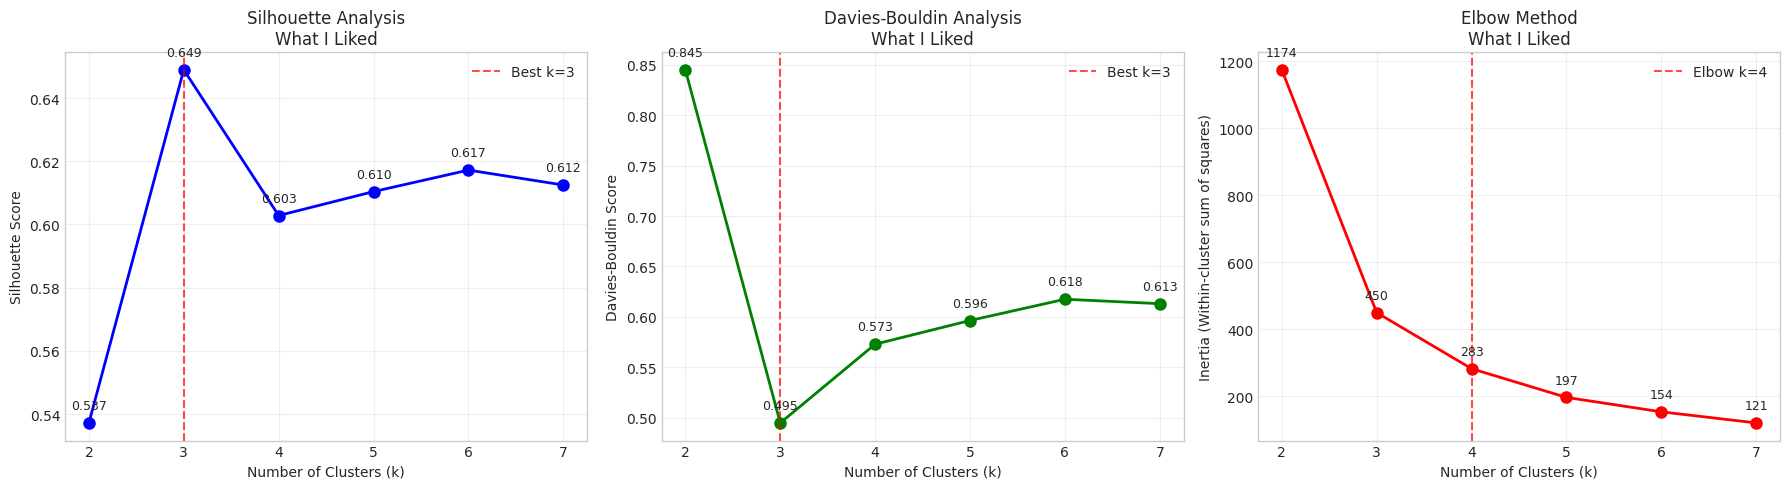


🎯 Analyzing optimal k for: Suggestions for Improvement
   Testing k=2... Silhouette: 0.454
   Testing k=3... Silhouette: 0.454
   Testing k=3... Silhouette: 0.611
   Testing k=4... Silhouette: 0.611
   Testing k=4... Silhouette: 0.546
   Testing k=5... Silhouette: 0.546
   Testing k=5... Silhouette: 0.531
   Testing k=6... Silhouette: 0.531
   Testing k=6... Silhouette: 0.583
   Testing k=7... Silhouette: 0.583
   Testing k=7... Silhouette: 0.542

   📊 Results:
      Best k (Silhouette): 3 (score: 0.611)
      Suggested k (Elbow): 4
Silhouette: 0.542

   📊 Results:
      Best k (Silhouette): 3 (score: 0.611)
      Suggested k (Elbow): 4


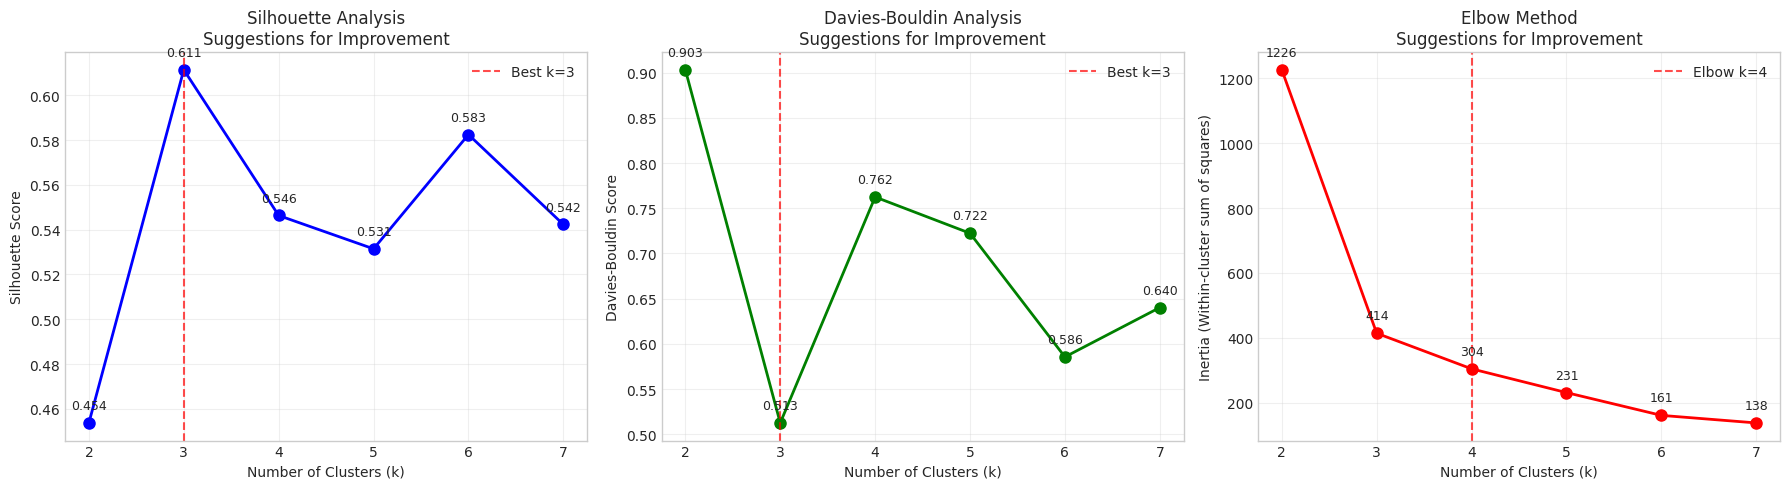


🎯 OPTIMAL K SELECTION SUMMARY

   What I Liked:
      📈 Best k (Silhouette): 3 (score: 0.649)
      📈 Suggested k (Elbow): 4
      ✅ Selected k for clustering: 3

   Suggestions for Improvement:
      📈 Best k (Silhouette): 3 (score: 0.611)
      📈 Suggested k (Elbow): 4
      ✅ Selected k for clustering: 3

✅ K-selection analysis completed!


In [13]:
# ====================================================================
# MODEL SELECTION - OPTIMAL K ANALYSIS
# ====================================================================

print("\n🔍 Phase 2: Optimal K Selection Analysis")
print("="*45)

def find_optimal_k(X, column_name, k_range=range(2, 8)):
    """Find optimal number of clusters using multiple methods"""
    print(f"\n🎯 Analyzing optimal k for: {column_name}")
    
    silhouette_scores = []
    davies_bouldin_scores = []
    inertias = []
    k_values = list(k_range)
    
    # Test different k values
    for k in k_values:
        print(f"   Testing k={k}...", end=" ")
        
        # Fit KMeans
        model, labels = clustering_analyzer.fit_kmeans(X, n_clusters=k)
        
        # Calculate metrics
        silhouette, davies_bouldin = clustering_analyzer.evaluate_clustering(X, labels, f"KMeans-k{k}")
        
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        inertias.append(model.inertia_)
        
        print(f"Silhouette: {silhouette:.3f}" if silhouette else "Silhouette: N/A")
    
    # Find optimal k
    valid_silhouette = [s for s in silhouette_scores if s is not None]
    if valid_silhouette:
        best_k_silhouette = k_values[silhouette_scores.index(max(valid_silhouette))]
        max_silhouette = max(valid_silhouette)
    else:
        best_k_silhouette = k_values[0]
        max_silhouette = 0
    
    # Elbow method (simplified)
    elbow_k = k_values[0]  # Default
    if len(inertias) > 2:
        # Find the point with maximum curvature (simplified elbow detection)
        diffs = np.diff(inertias)
        diffs2 = np.diff(diffs)
        if len(diffs2) > 0:
            elbow_idx = np.argmax(np.abs(diffs2)) + 2  # +2 because of double diff
            elbow_k = k_values[min(elbow_idx, len(k_values)-1)]
    
    results = {
        'k_values': k_values,
        'silhouette_scores': silhouette_scores,
        'davies_bouldin_scores': davies_bouldin_scores,
        'inertias': inertias,
        'best_k_silhouette': best_k_silhouette,
        'max_silhouette_score': max_silhouette,
        'suggested_k_elbow': elbow_k
    }
    
    print(f"\n   📊 Results:")
    print(f"      Best k (Silhouette): {best_k_silhouette} (score: {max_silhouette:.3f})")
    print(f"      Suggested k (Elbow): {elbow_k}")
    
    return results

def plot_k_analysis(k_analysis_results, column_name):
    """Plot k-selection analysis results"""
    results = k_analysis_results
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Silhouette Scores
    valid_silhouette = [(k, s) for k, s in zip(results['k_values'], results['silhouette_scores']) if s is not None]
    if valid_silhouette:
        k_vals, sil_scores = zip(*valid_silhouette)
        axes[0].plot(k_vals, sil_scores, 'bo-', linewidth=2, markersize=8)
        axes[0].axvline(x=results['best_k_silhouette'], color='red', linestyle='--', alpha=0.7, 
                       label=f'Best k={results["best_k_silhouette"]}')
        axes[0].set_xlabel('Number of Clusters (k)')
        axes[0].set_ylabel('Silhouette Score')
        axes[0].set_title(f'Silhouette Analysis\n{column_name}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Add value labels
        for k, score in zip(k_vals, sil_scores):
            axes[0].annotate(f'{score:.3f}', (k, score), 
                           textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    # Plot 2: Davies-Bouldin Scores (lower is better)
    valid_davies = [(k, d) for k, d in zip(results['k_values'], results['davies_bouldin_scores']) if d is not None]
    if valid_davies:
        k_vals, db_scores = zip(*valid_davies)
        axes[1].plot(k_vals, db_scores, 'go-', linewidth=2, markersize=8)
        best_db_k = k_vals[np.argmin(db_scores)]
        axes[1].axvline(x=best_db_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_db_k}')
        axes[1].set_xlabel('Number of Clusters (k)')
        axes[1].set_ylabel('Davies-Bouldin Score')
        axes[1].set_title(f'Davies-Bouldin Analysis\n{column_name}')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for k, score in zip(k_vals, db_scores):
            axes[1].annotate(f'{score:.3f}', (k, score), 
                           textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    # Plot 3: Elbow Method
    axes[2].plot(results['k_values'], results['inertias'], 'ro-', linewidth=2, markersize=8)
    axes[2].axvline(x=results['suggested_k_elbow'], color='red', linestyle='--', alpha=0.7, 
                   label=f'Elbow k={results["suggested_k_elbow"]}')
    axes[2].set_xlabel('Number of Clusters (k)')
    axes[2].set_ylabel('Inertia (Within-cluster sum of squares)')
    axes[2].set_title(f'Elbow Method\n{column_name}')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels
    for k, inertia in zip(results['k_values'], results['inertias']):
        axes[2].annotate(f'{inertia:.0f}', (k, inertia), 
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Perform k-selection analysis for both columns
k_selection_results = {}

for column_key in vectorization_results:
    column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions for Improvement'
    lda_matrix = vectorization_results[column_key]['lda_matrix']
    
    # Find optimal k
    k_analysis = find_optimal_k(lda_matrix, column_name, k_range=range(2, 8))
    k_selection_results[column_key] = k_analysis
    
    # Plot analysis
    plot_k_analysis(k_analysis, column_name)

# Summary of selected k values
print(f"\n🎯 OPTIMAL K SELECTION SUMMARY")
print("="*35)
for column_key, results in k_selection_results.items():
    column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions for Improvement'
    print(f"\n   {column_name}:")
    print(f"      📈 Best k (Silhouette): {results['best_k_silhouette']} (score: {results['max_silhouette_score']:.3f})")
    print(f"      📈 Suggested k (Elbow): {results['suggested_k_elbow']}")
    print(f"      ✅ Selected k for clustering: {results['best_k_silhouette']}")

print(f"\n✅ K-selection analysis completed!")
print("="*45)

## 4. Vectorization and lda topic modeling

In [14]:
# ====================================================================
# VECTORIZATION AND LDA TOPIC MODELING
# ====================================================================

print("\n🔄 Vectorization and LDA Topic Modeling")
print("="*45)

def perform_vectorization_and_lda(df, text_column, n_topics=3):
    """Perform Count Vectorization and LDA Topic Modeling"""
    print(f"\n📊 Processing: {text_column.replace('processed_', '').replace('_', ' ').title()}")
    
    # Clean data
    df_clean = df[df[text_column].notna() & (df[text_column].str.len() > 5)].copy()
    print(f"   Valid samples: {len(df_clean)} (from {len(df)} total)")
    
    if len(df_clean) == 0:
        print(f"   ❌ No valid data for {text_column}")
        return None
    
    # Count Vectorization
    print("   🔄 Count Vectorization...")
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
    doc_term_matrix = vectorizer.fit_transform(df_clean[text_column])
    print(f"   📊 Matrix shape: {doc_term_matrix.shape}")
    
    # LDA Topic Modeling
    print("   🔄 LDA Topic Modeling...")
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_matrix = lda.fit_transform(doc_term_matrix)
    print(f"   📊 LDA shape: {lda_matrix.shape}")
    
    # Extract topic keywords
    feature_names = vectorizer.get_feature_names_out()
    topic_keywords = []
    print("   📝 Topic Keywords:")
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
        topic_str = f"Topic {topic_idx + 1}: {', '.join(top_words[:5])}"
        topic_keywords.append(topic_str)
        print(f"      {topic_str}")
    
    return {
        'df_clean': df_clean,
        'vectorizer': vectorizer,
        'doc_term_matrix': doc_term_matrix,
        'lda_model': lda,
        'lda_matrix': lda_matrix,
        'dominant_topics': np.argmax(lda_matrix, axis=1),
        'topic_keywords': topic_keywords,
        'n_topics': n_topics
    }

# Process both columns
vectorization_results = {}

# "What I liked" column
liked_results = perform_vectorization_and_lda(df, 'processed_liked', n_topics=3)
if liked_results:
    vectorization_results['liked'] = liked_results

# "Suggestions for improvement" column
suggestions_results = perform_vectorization_and_lda(df, 'processed_suggestions', n_topics=3)
if suggestions_results:
    vectorization_results['suggestions'] = suggestions_results

print(f"\n✅ Vectorization completed for {len(vectorization_results)} columns!")
print("="*45)


🔄 Vectorization and LDA Topic Modeling

📊 Processing: Liked
   Valid samples: 8372 (from 8417 total)
   🔄 Count Vectorization...
   📊 Matrix shape: (8372, 1000)
   🔄 LDA Topic Modeling...
   📊 LDA shape: (8372, 3)
   📝 Topic Keywords:
      Topic 1: văn_phòng, đẹp, lương, làm_việc, đi
      Topic 2: công_việc, đào_tạo, overtime, công, trường
      Topic 3: làm_việc, môi_trường, lương, đồng_nghiệp, thân_thiện

📊 Processing: Suggestions
   Valid samples: 8273 (from 8417 total)
   🔄 Count Vectorization...
   📊 Matrix shape: (8273, 1000)
   🔄 LDA Topic Modeling...
   📊 LDA shape: (8273, 3)
   📝 Topic Keywords:
      Topic 1: đội, công_việc, hoạt_động, làm_việc, công
      Topic 2: lương, dự_án, tiền, chế_độ, thưởng
      Topic 3: hơi, văn_phòng, làm_việc, trình, cải_thiện

✅ Vectorization completed for 2 columns!


## 5. Apply multiple clustering


🔄 Step 3: Applying Multiple Clustering Algorithms

🔄 Applying Multiple Clustering Algorithms

🎯 Clustering: What I Liked (k=3)
   🔄 KMeans...
      Distribution: Counter({2: 4246, 1: 2916, 0: 1210})
      Silhouette: 0.6254
   🔄 Agglomerative...
      Distribution: Counter({2: 4246, 1: 2916, 0: 1210})
      Silhouette: 0.6254
   🔄 Agglomerative...
      Distribution: Counter({0: 4549, 1: 2862, 2: 961})
      Silhouette: 0.6020
   🔄 DBSCAN...
      Distribution: Counter({0: 4549, 1: 2862, 2: 961})
      Silhouette: 0.6020
   🔄 DBSCAN...
      Clusters: 1, Noise: 0

🎯 Clustering: Suggestions for Improvement (k=3)
   🔄 KMeans...
      Clusters: 1, Noise: 0

🎯 Clustering: Suggestions for Improvement (k=3)
   🔄 KMeans...
      Distribution: Counter({1: 3108, 2: 2793, 0: 2372})
      Silhouette: 0.6016
   🔄 Agglomerative...
      Distribution: Counter({1: 3108, 2: 2793, 0: 2372})
      Silhouette: 0.6016
   🔄 Agglomerative...
      Distribution: Counter({0: 3172, 1: 2887, 2: 2214})
      Si

,Algorithm,Silhouette,Davies-Bouldin,Clusters,Noise Points,Composite Score
0,KMEANS,0.6254,0.5025,3,0,0.5752
1,AGGLOMERATIVE,0.6020,0.4981,3,0,0.5522
2,DBSCAN,N/A,N/A,1,0,0.0000



   🥇 BEST ALGORITHM: KMEANS
      Composite Score: 0.5752
      Silhouette Score: 0.6254
      Davies-Bouldin: 0.5025
      Number of Clusters: 3

🏆 Model Comparison: Suggestions for Improvement

   📋 Algorithm Comparison:


,Algorithm,Silhouette,Davies-Bouldin,Clusters,Noise Points,Composite Score
0,KMEANS,0.6016,0.5384,3,0,0.5477
1,AGGLOMERATIVE,0.5842,0.5813,3,0,0.5261
2,DBSCAN,N/A,N/A,1,0,0.0000



   🥇 BEST ALGORITHM: KMEANS
      Composite Score: 0.5477
      Silhouette Score: 0.6016
      Davies-Bouldin: 0.5384
      Number of Clusters: 3


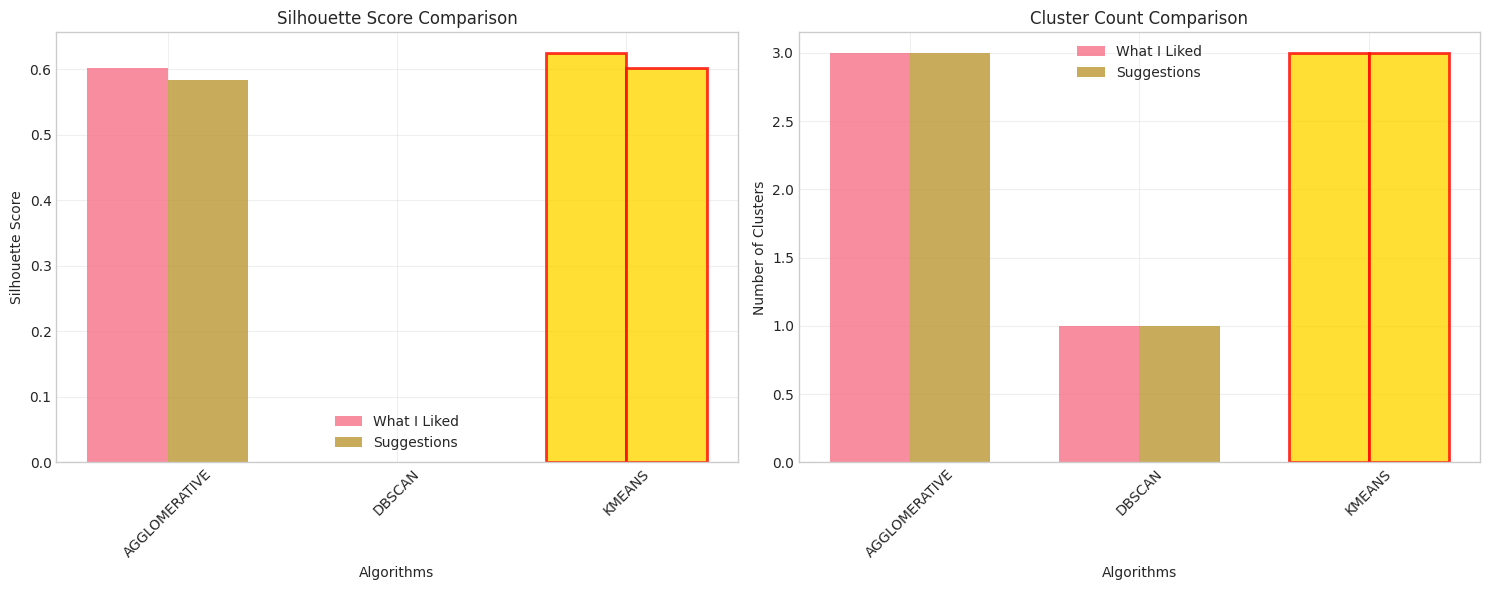


🎯 SELECTED ALGORITHMS SUMMARY
   What I Liked: KMEANS
   Suggestions for Improvement: KMEANS

✅ Model comparison and selection completed!


In [20]:
class AdvancedClusteringAnalyzer:
    """Perform clustering using different algorithms."""
    def __init__(self, n_clusters=4):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)

    def perform_kmeans(self, vectors):
        """Perform KMeans clustering."""
        return self.kmeans.fit_predict(vectors)


print("\n🔄 Step 3: Applying Multiple Clustering Algorithms")
print("="*60)

# Import evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

def apply_clustering_algorithms(lda_matrix, column_name, n_clusters=3, apply_dbscan=True):
    """
    Apply multiple clustering algorithms: KMeans, Agglomerative, and DBSCAN
    Following the exact approach from bai2_clustering_main.ipynb
    """
    print(f"\n🎯 Applying clustering algorithms for: {column_name}")
    print(f"   Using n_clusters = {n_clusters}")
    
    clustering_results = {}
    
    # 1. KMeans Clustering (same as bai2_clustering)
    print("   🔄 Applying KMeans clustering...")
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(lda_matrix)
    
    clustering_results['kmeans'] = {
        'model': kmeans,
        'labels': kmeans_labels,
        'cluster_centers': kmeans.cluster_centers_
    }
    
    print(f"      ✅ KMeans completed - Cluster distribution: {Counter(kmeans_labels)}")
    
    # 2. Agglomerative Clustering (same as bai2_clustering)
    print("   🔄 Applying Agglomerative clustering...")
    # Convert sparse matrix to dense for Agglomerative Clustering
    lda_matrix_dense = lda_matrix.toarray() if hasattr(lda_matrix, 'toarray') else lda_matrix
    
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(lda_matrix_dense)
    
    clustering_results['agglomerative'] = {
        'model': agg_clustering,
        'labels': agg_labels
    }
    
    print(f"      ✅ Agglomerative completed - Cluster distribution: {Counter(agg_labels)}")
    
    # 3. DBSCAN (same approach as bai2_clustering)
    if apply_dbscan:
        print("   🔄 Applying DBSCAN clustering...")
        
        # Apply PCA for dimensionality reduction (same as bai2_clustering)
        pca_components = min(50, lda_matrix.shape[1])  # Adaptive PCA components
        pca = PCA(n_components=pca_components, random_state=42)
        lda_pca = pca.fit_transform(lda_matrix_dense)
        
        # DBSCAN parameters (same range as bai2_clustering)
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan_labels = dbscan.fit_predict(lda_pca)
        
        clustering_results['dbscan'] = {
            'model': dbscan,
            'labels': dbscan_labels,
            'pca_data': lda_pca,
            'pca_model': pca
        }
        
        # Count clusters and noise points
        n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        print(f"      ✅ DBSCAN completed - Clusters: {n_clusters_dbscan}, Noise points: {n_noise}")
        print(f"      📊 DBSCAN distribution: {Counter(dbscan_labels)}")
    
    return clustering_results

# ====================================================================
# MULTIPLE CLUSTERING ALGORITHMS
# ====================================================================

print("\n🔄 Applying Multiple Clustering Algorithms")
print("="*45)

def apply_clustering_algorithms(lda_matrix, column_name, n_clusters=3):
    """Apply KMeans, Agglomerative, and DBSCAN clustering with evaluation metrics"""
    print(f"\n🎯 Clustering: {column_name} (k={n_clusters})")
    
    clustering_results = {}
    lda_dense = lda_matrix.toarray() if hasattr(lda_matrix, 'toarray') else lda_matrix
    
    # 1. KMeans Clustering
    print("   🔄 KMeans...")
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(lda_matrix)
    
    # Calculate evaluation metrics for KMeans
    try:
        kmeans_silhouette = silhouette_score(lda_dense, kmeans_labels) if len(set(kmeans_labels)) > 1 else None
        kmeans_davies_bouldin = davies_bouldin_score(lda_dense, kmeans_labels) if len(set(kmeans_labels)) > 1 else None
    except:
        kmeans_silhouette = None
        kmeans_davies_bouldin = None
    
    clustering_results['kmeans'] = {
        'model': kmeans,
        'labels': kmeans_labels,
        'centers': kmeans.cluster_centers_,
        'silhouette': kmeans_silhouette,
        'davies_bouldin': kmeans_davies_bouldin,
        'n_clusters': len(set(kmeans_labels)),
        'n_noise': 0
    }
    print(f"      Distribution: {Counter(kmeans_labels)}")
    if kmeans_silhouette:
        print(f"      Silhouette: {kmeans_silhouette:.4f}")
    
    # 2. Agglomerative Clustering
    print("   🔄 Agglomerative...")
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(lda_dense)
    
    # Calculate evaluation metrics for Agglomerative
    try:
        agg_silhouette = silhouette_score(lda_dense, agg_labels) if len(set(agg_labels)) > 1 else None
        agg_davies_bouldin = davies_bouldin_score(lda_dense, agg_labels) if len(set(agg_labels)) > 1 else None
    except:
        agg_silhouette = None
        agg_davies_bouldin = None
    
    clustering_results['agglomerative'] = {
        'model': agg_clustering,
        'labels': agg_labels,
        'silhouette': agg_silhouette,
        'davies_bouldin': agg_davies_bouldin,
        'n_clusters': len(set(agg_labels)),
        'n_noise': 0
    }
    print(f"      Distribution: {Counter(agg_labels)}")
    if agg_silhouette:
        print(f"      Silhouette: {agg_silhouette:.4f}")
    
    # 3. DBSCAN (with PCA preprocessing)
    print("   🔄 DBSCAN...")
    pca_components = min(50, lda_matrix.shape[1])
    pca = PCA(n_components=pca_components, random_state=42)
    lda_pca = pca.fit_transform(lda_dense)
    
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(lda_pca)
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    # Calculate evaluation metrics for DBSCAN (only if we have clusters)
    try:
        if n_clusters_dbscan > 1 and n_noise < len(dbscan_labels):
            # Filter out noise points for evaluation
            non_noise_mask = dbscan_labels != -1
            if np.sum(non_noise_mask) > 1:
                dbscan_silhouette = silhouette_score(lda_pca[non_noise_mask], dbscan_labels[non_noise_mask])
                dbscan_davies_bouldin = davies_bouldin_score(lda_pca[non_noise_mask], dbscan_labels[non_noise_mask])
            else:
                dbscan_silhouette = None
                dbscan_davies_bouldin = None
        else:
            dbscan_silhouette = None
            dbscan_davies_bouldin = None
    except:
        dbscan_silhouette = None
        dbscan_davies_bouldin = None
    
    clustering_results['dbscan'] = {
        'model': dbscan,
        'labels': dbscan_labels,
        'pca_data': lda_pca,
        'pca_model': pca,
        'silhouette': dbscan_silhouette,
        'davies_bouldin': dbscan_davies_bouldin,
        'n_clusters': n_clusters_dbscan,
        'n_noise': n_noise
    }
    print(f"      Clusters: {n_clusters_dbscan}, Noise: {n_noise}")
    if dbscan_silhouette:
        print(f"      Silhouette: {dbscan_silhouette:.4f}")
    
    return clustering_results

# Apply clustering to both columns
final_clustering_results = {}

# Process both columns
for column_key in vectorization_results:
    column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions for Improvement'
    
    # Use optimal k if available, otherwise default to 3
    optimal_k = 3
    if column_key in k_selection_results:
        optimal_k = k_selection_results[column_key].get('best_k_silhouette', 3)
    
    clustering_results = apply_clustering_algorithms(
        vectorization_results[column_key]['lda_matrix'],
        column_name,
        n_clusters=optimal_k
    )
    final_clustering_results[column_key] = clustering_results

print(f"\n✅ Clustering completed for {len(final_clustering_results)} columns!")
print("="*45)

# ====================================================================
# 4. MODEL COMPARISON - SELECT BEST ALGORITHM
# ====================================================================

print("\n📊 Phase 4: Model Comparison and Selection")
print("="*45)

def compare_clustering_algorithms(clustering_results, column_name):
    """Compare clustering algorithms and select the best one"""
    print(f"\n🏆 Model Comparison: {column_name}")
    
    # Create comparison table
    comparison_data = []
    best_algorithm = None
    best_score = -1
    
    for algo_name, results in clustering_results.items():
        if results is None:
            continue
            
        # Calculate composite score (prioritize Silhouette, lower Davies-Bouldin is better)
        silhouette = results['silhouette'] if results['silhouette'] is not None else 0
        davies_bouldin = results['davies_bouldin'] if results['davies_bouldin'] is not None else float('inf')
        
        # Composite score: Silhouette - normalized Davies-Bouldin
        # (Higher silhouette is better, lower Davies-Bouldin is better)
        if davies_bouldin != float('inf') and davies_bouldin > 0:
            composite_score = silhouette - (davies_bouldin / 10)  # Normalize DB score
        else:
            composite_score = silhouette
        
        comparison_data.append({
            'Algorithm': algo_name.upper(),
            'Silhouette': f"{silhouette:.4f}" if silhouette else "N/A",
            'Davies-Bouldin': f"{davies_bouldin:.4f}" if davies_bouldin != float('inf') else "N/A",
            'Clusters': results['n_clusters'],
            'Noise Points': results['n_noise'],
            'Composite Score': f"{composite_score:.4f}" if composite_score > -1 else "N/A"
        })
        
        # Track best algorithm
        if composite_score > best_score:
            best_score = composite_score
            best_algorithm = algo_name
    
    # Display comparison table
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\n   📋 Algorithm Comparison:")
    display(comparison_df)
    
    # Highlight best algorithm
    if best_algorithm:
        print(f"\n   🥇 BEST ALGORITHM: {best_algorithm.upper()}")
        print(f"      Composite Score: {best_score:.4f}")
        
        # Display detailed results for best algorithm
        best_results = clustering_results[best_algorithm]
        print(f"      Silhouette Score: {best_results['silhouette']:.4f}" if best_results['silhouette'] else "      Silhouette Score: N/A")
        print(f"      Davies-Bouldin: {best_results['davies_bouldin']:.4f}" if best_results['davies_bouldin'] else "      Davies-Bouldin: N/A")
        print(f"      Number of Clusters: {best_results['n_clusters']}")
        if best_results['n_noise'] > 0:
            print(f"      Noise Points: {best_results['n_noise']}")
    
    return best_algorithm, comparison_df

def plot_algorithm_comparison(comparison_results):
    """Create visualization comparing algorithm performance"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Prepare data for plotting
    all_algorithms = set()
    for column_key, (best_algo, comp_df) in comparison_results.items():
        all_algorithms.update(comp_df['Algorithm'].tolist())
    
    all_algorithms = sorted(list(all_algorithms))
    
    # Plot 1: Silhouette Scores Comparison
    x_pos = np.arange(len(all_algorithms))
    width = 0.35
    
    for i, (column_key, (best_algo, comp_df)) in enumerate(comparison_results.items()):
        column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions'
        
        # Prepare silhouette scores
        silhouette_values = []
        for algo in all_algorithms:
            matching_rows = comp_df[comp_df['Algorithm'] == algo]
            if len(matching_rows) > 0 and matching_rows.iloc[0]['Silhouette'] != 'N/A':
                silhouette_values.append(float(matching_rows.iloc[0]['Silhouette']))
            else:
                silhouette_values.append(0)
        
        bars = axes[0].bar(x_pos + i*width, silhouette_values, width, 
                          label=column_name, alpha=0.8)
        
        # Highlight best algorithm
        for j, (algo, bar) in enumerate(zip(all_algorithms, bars)):
            if algo.lower() == best_algo:
                bar.set_color('gold')
                bar.set_edgecolor('red')
                bar.set_linewidth(2)
    
    axes[0].set_xlabel('Algorithms')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title('Silhouette Score Comparison')
    axes[0].set_xticks(x_pos + width/2)
    axes[0].set_xticklabels(all_algorithms, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Cluster Count Comparison
    for i, (column_key, (best_algo, comp_df)) in enumerate(comparison_results.items()):
        column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions'
        
        # Prepare cluster counts
        cluster_counts = []
        for algo in all_algorithms:
            matching_rows = comp_df[comp_df['Algorithm'] == algo]
            if len(matching_rows) > 0:
                cluster_counts.append(matching_rows.iloc[0]['Clusters'])
            else:
                cluster_counts.append(0)
        
        bars = axes[1].bar(x_pos + i*width, cluster_counts, width, 
                          label=column_name, alpha=0.8)
        
        # Highlight best algorithm
        for j, (algo, bar) in enumerate(zip(all_algorithms, bars)):
            if algo.lower() == best_algo:
                bar.set_color('gold')
                bar.set_edgecolor('red')
                bar.set_linewidth(2)
    
    axes[1].set_xlabel('Algorithms')
    axes[1].set_ylabel('Number of Clusters')
    axes[1].set_title('Cluster Count Comparison')
    axes[1].set_xticks(x_pos + width/2)
    axes[1].set_xticklabels(all_algorithms, rotation=45)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Compare algorithms for both columns
comparison_results = {}
selected_algorithms = {}

for column_key in final_clustering_results:
    column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions for Improvement'
    clustering_results = final_clustering_results[column_key]
    
    best_algorithm, comparison_df = compare_clustering_algorithms(clustering_results, column_name)
    comparison_results[column_key] = (best_algorithm, comparison_df)
    selected_algorithms[column_key] = best_algorithm

# Create comparison visualization
if len(comparison_results) > 0:
    plot_algorithm_comparison(comparison_results)

# Summary of selected algorithms
print(f"\n🎯 SELECTED ALGORITHMS SUMMARY")
print("="*35)
for column_key, best_algo in selected_algorithms.items():
    column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions for Improvement'
    print(f"   {column_name}: {best_algo.upper()}")

print(f"\n✅ Model comparison and selection completed!")
print("="*45)


🎨 Phase 5: Comprehensive Clustering Visualizations

📊 Creating visualizations for: What I Liked
   🎯 Selected Algorithm: KMEANS
   📐 PCA applied: (8372, 3) -> (8372, 2)
   📈 Explained variance ratio: [0.62410833 0.37589167]
   📊 Clustering Metrics:
      • Silhouette Score: 0.6254
      • Davies-Bouldin Index: 0.5025
      • Number of Clusters: 3

📊 Creating visualizations for: Suggestions for Improvement
   🎯 Selected Algorithm: KMEANS
   📐 PCA applied: (8273, 3) -> (8273, 2)
   📈 Explained variance ratio: [0.56613242 0.43386758]
   📊 Clustering Metrics:
      • Silhouette Score: 0.6016
      • Davies-Bouldin Index: 0.5384
      • Number of Clusters: 3


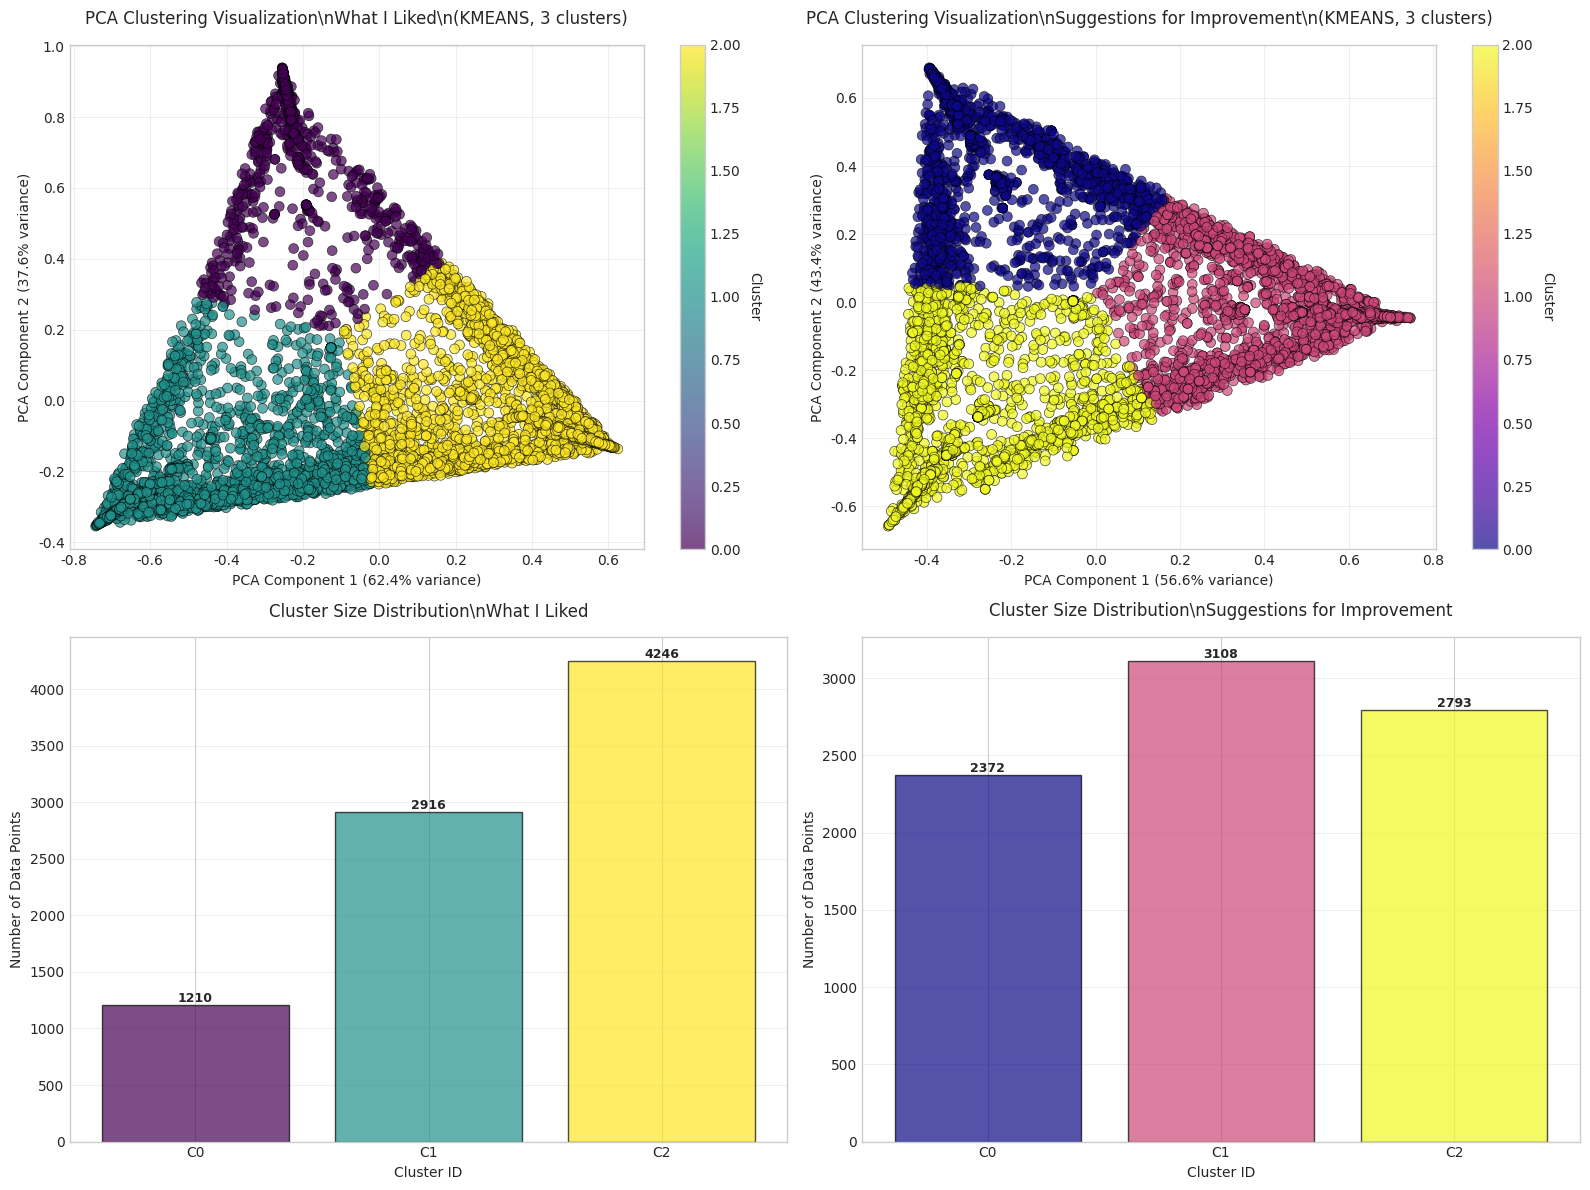


📈 Algorithm Performance Comparison


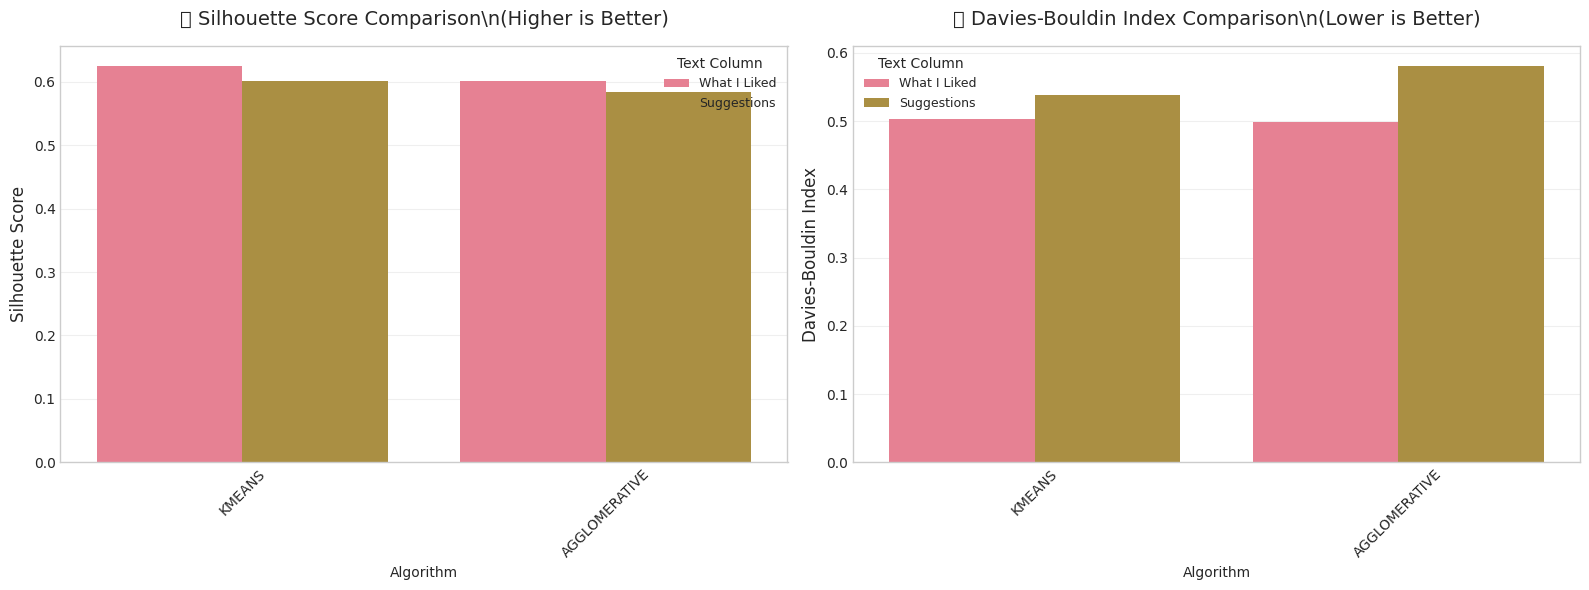


✅ Comprehensive clustering visualizations completed!


In [36]:
# ====================================================================
# COMPREHENSIVE CLUSTERING VISUALIZATION - PCA PLOTS
# ====================================================================

print("\n🎨 Phase 5: Comprehensive Clustering Visualizations")
print("="*55)

def create_comprehensive_pca_visualization(vectorization_results, final_clustering_results, selected_algorithms):
    """
    Create comprehensive PCA visualizations for the selected clustering algorithms
    Similar to the PCA charts from bai2_clustering
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Set up the figure
    n_columns = len(final_clustering_results)
    fig, axes = plt.subplots(2, n_columns, figsize=(8*n_columns, 12))
    
    if n_columns == 1:
        axes = axes.reshape(-1, 1)
    
    colors = ['viridis', 'plasma', 'coolwarm', 'Set2']
    
    for col_idx, (column_key, clustering_results) in enumerate(final_clustering_results.items()):
        column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions for Improvement'
        best_algorithm = selected_algorithms.get(column_key, 'kmeans')
        
        print(f"\n📊 Creating visualizations for: {column_name}")
        print(f"   🎯 Selected Algorithm: {best_algorithm.upper()}")
        
        # Get the vectorization results for this column
        if column_key not in vectorization_results:
            print(f"   ⚠️  No vectorization results found for {column_key}")
            continue
            
        lda_matrix = vectorization_results[column_key]['lda_matrix']
        
        # Get clustering results for the best algorithm
        if best_algorithm not in clustering_results or clustering_results[best_algorithm] is None:
            print(f"   ⚠️  No results found for algorithm {best_algorithm}")
            continue
            
        cluster_labels = clustering_results[best_algorithm]['labels']
        
        # Apply PCA for visualization (2D)
        pca = PCA(n_components=2, random_state=42)
        pca_coords = pca.fit_transform(lda_matrix)
        
        print(f"   📐 PCA applied: {lda_matrix.shape} -> {pca_coords.shape}")
        print(f"   📈 Explained variance ratio: {pca.explained_variance_ratio_}")
        
        # Plot 1: PCA visualization of clusters
        ax1 = axes[0, col_idx]
        
        # Create scatter plot
        unique_labels = np.unique(cluster_labels)
        n_clusters_real = len(unique_labels[unique_labels >= 0])  # Exclude noise (-1) if present
        
        scatter = ax1.scatter(pca_coords[:, 0], pca_coords[:, 1], 
                            c=cluster_labels, cmap=colors[col_idx % len(colors)], 
                            alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        ax1.set_title(f'PCA Clustering Visualization\\n{column_name}\\n({best_algorithm.upper()}, {n_clusters_real} clusters)', 
                     fontsize=12, pad=15)
        ax1.set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=10)
        ax1.set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Cluster', rotation=270, labelpad=15)
        
        # Plot 2: Cluster size distribution
        ax2 = axes[1, col_idx]
        
        # Count points per cluster
        unique_labels_for_count = unique_labels[unique_labels >= 0]  # Exclude noise
        cluster_sizes = [np.sum(cluster_labels == label) for label in unique_labels_for_count]
        
        if len(unique_labels_for_count) > 0:
            bars = ax2.bar(range(len(unique_labels_for_count)), cluster_sizes, 
                          color=plt.cm.get_cmap(colors[col_idx % len(colors)])(np.linspace(0, 1, len(unique_labels_for_count))),
                          alpha=0.7, edgecolor='black', linewidth=1)
            
            ax2.set_title(f'Cluster Size Distribution\\n{column_name}', fontsize=12, pad=15)
            ax2.set_xlabel('Cluster ID', fontsize=10)
            ax2.set_ylabel('Number of Data Points', fontsize=10)
            ax2.set_xticks(range(len(unique_labels_for_count)))
            ax2.set_xticklabels([f'C{i}' for i in unique_labels_for_count])
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar, size in zip(bars, cluster_sizes):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{size}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Print clustering metrics
        metrics = clustering_results[best_algorithm]
        print(f"   📊 Clustering Metrics:")
        if metrics['silhouette'] is not None:
            print(f"      • Silhouette Score: {metrics['silhouette']:.4f}")
        if metrics['davies_bouldin'] is not None:
            print(f"      • Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
        print(f"      • Number of Clusters: {metrics['n_clusters']}")
        if metrics['n_noise'] > 0:
            print(f"      • Noise Points: {metrics['n_noise']}")
    
    plt.tight_layout()
    plt.show()
    
    return True

def create_algorithm_performance_comparison():
    """Create a performance comparison chart across algorithms and columns"""
    
    if len(comparison_results) == 0:
        print("⚠️  No comparison results available")
        return
    
    print(f"\n📈 Algorithm Performance Comparison")
    
    # Prepare data for comparison
    all_metrics = []
    
    for column_key, (best_algo, comp_df) in comparison_results.items():
        column_name = 'What I Liked' if column_key == 'liked' else 'Suggestions'
        
        for _, row in comp_df.iterrows():
            if row['Silhouette'] != 'N/A':
                all_metrics.append({
                    'Column': column_name,
                    'Algorithm': row['Algorithm'],
                    'Silhouette': float(row['Silhouette']),
                    'Davies_Bouldin': float(row['Davies-Bouldin']) if row['Davies-Bouldin'] != 'N/A' else None,
                    'Is_Best': row['Algorithm'].lower() == best_algo
                })
    
    if len(all_metrics) == 0:
        print("⚠️  No valid metrics found for comparison")
        return
    
    # Create comparison plot
    metrics_df = pd.DataFrame(all_metrics)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Silhouette Score Comparison
    sns.barplot(data=metrics_df, x='Algorithm', y='Silhouette', hue='Column', ax=axes[0])
    axes[0].set_title('🏆 Silhouette Score Comparison\\n(Higher is Better)', fontsize=14, pad=15)
    axes[0].set_ylabel('Silhouette Score', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].legend(title='Text Column', title_fontsize=10, fontsize=9)
    
    # Plot 2: Davies-Bouldin Index Comparison (if available)
    db_metrics = metrics_df[metrics_df['Davies_Bouldin'].notna()]
    if len(db_metrics) > 0:
        sns.barplot(data=db_metrics, x='Algorithm', y='Davies_Bouldin', hue='Column', ax=axes[1])
        axes[1].set_title('📉 Davies-Bouldin Index Comparison\\n(Lower is Better)', fontsize=14, pad=15)
        axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].legend(title='Text Column', title_fontsize=10, fontsize=9)
    else:
        axes[1].text(0.5, 0.5, 'Davies-Bouldin Index\\nNot Available', 
                    ha='center', va='center', transform=axes[1].transAxes,
                    fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1].set_title('📉 Davies-Bouldin Index', fontsize=14, pad=15)
    
    plt.tight_layout()
    plt.show()

# Execute visualizations if results are available
if 'final_clustering_results' in locals() and 'selected_algorithms' in locals():
    
    # Create comprehensive PCA visualizations
    success = create_comprehensive_pca_visualization(
        vectorization_results, 
        final_clustering_results, 
        selected_algorithms
    )
    
    # Create algorithm performance comparison
    if 'comparison_results' in locals():
        create_algorithm_performance_comparison()
    
    print(f"\n✅ Comprehensive clustering visualizations completed!")
    print("="*55)
    
else:
    print("⚠️  Required clustering results not found.")
    print("   Please ensure previous clustering analysis cells have been executed.")
    print("   Required variables: final_clustering_results, selected_algorithms, vectorization_results")

## 6. MODEL INTERPRETATION - UNDERSTAND SELECTED MODELS

In [30]:
class KeywordInterpreter:
    """Interpret the meaning of clusters based on top words."""
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        self.feature_names = self.vectorizer.get_feature_names_out()

    def get_top_keywords(self, vectors, labels, n_terms=10):
        """Get top keywords for each cluster."""
        # Convert to dense array if needed
        if hasattr(vectors, 'toarray'):
            vectors_dense = vectors.toarray()
        else:
            vectors_dense = vectors
            
        df = pd.DataFrame(vectors_dense, columns=self.feature_names)
        df['cluster'] = labels
        
        top_keywords = {}
        unique_clusters = sorted(df['cluster'].unique())
        for cluster_id in unique_clusters:
            if cluster_id != -1:  # Skip noise points
                cluster_words = df[df['cluster'] == cluster_id].drop('cluster', axis=1).sum().sort_values(ascending=False).head(n_terms)
                top_keywords[cluster_id] = cluster_words.index.tolist()
        return top_keywords

# Fix: Use document-term matrices for keyword interpretation
print("🔧 Using document-term matrices for keyword interpretation...")

# Use the vectorizers from the existing pipeline
if 'liked' in vectorization_results and 'suggestions' in vectorization_results:
    print("✅ Using vectorization results from clustering pipeline")
    
    # Get the count vectorizers and document-term matrices
    vectorizer_liked = vectorization_results['liked']['vectorizer']
    vectorizer_suggestions = vectorization_results['suggestions']['vectorizer']
    
    # Use document-term matrices instead of LDA matrices for keyword extraction
    doc_term_matrix_liked = vectorization_results['liked']['doc_term_matrix']
    doc_term_matrix_suggestions = vectorization_results['suggestions']['doc_term_matrix']
    
    # Get cluster labels from the best performing algorithms
    if 'selected_algorithms' in globals() and 'final_clustering_results' in globals():
        if 'liked' in selected_algorithms and 'suggestions' in selected_algorithms:
            clusters_liked = final_clustering_results['liked'][selected_algorithms['liked']]['labels']
            clusters_suggestions = final_clustering_results['suggestions'][selected_algorithms['suggestions']]['labels']
            
            print(f"📊 Clusters found - Liked: {len(set(clusters_liked))}, Suggestions: {len(set(clusters_suggestions))}")
            
            # Create interpreters using count vectorizers and document-term matrices
            interpreter_liked = KeywordInterpreter(vectorizer_liked)
            top_keywords_liked = interpreter_liked.get_top_keywords(doc_term_matrix_liked, clusters_liked)
            
            interpreter_suggestions = KeywordInterpreter(vectorizer_suggestions)
            top_keywords_suggestions = interpreter_suggestions.get_top_keywords(doc_term_matrix_suggestions, clusters_suggestions)
            
            print("✅ Keyword Interpretation complete.")
            
            print("\nTop keywords for 'What I liked' clusters:")
            for cluster, keywords in top_keywords_liked.items():
                print(f"Cluster {cluster}: {', '.join(keywords[:8])}")
            
            print("\nTop keywords for 'Suggestions for improvement' clusters:")
            for cluster, keywords in top_keywords_suggestions.items():
                print(f"Cluster {cluster}: {', '.join(keywords[:8])}")
        else:
            print("❌ Selected algorithms not found. Using LDA topics as clusters...")
            # Create simple clusters based on dominant topics
            clusters_liked = vectorization_results['liked']['dominant_topics']
            clusters_suggestions = vectorization_results['suggestions']['dominant_topics']
            
            print(f"📊 Topics found - Liked: {len(set(clusters_liked))}, Suggestions: {len(set(clusters_suggestions))}")
            
            # Create interpreters using count vectorizers
            interpreter_liked = KeywordInterpreter(vectorizer_liked)
            top_keywords_liked = interpreter_liked.get_top_keywords(doc_term_matrix_liked, clusters_liked)
            
            interpreter_suggestions = KeywordInterpreter(vectorizer_suggestions)
            top_keywords_suggestions = interpreter_suggestions.get_top_keywords(doc_term_matrix_suggestions, clusters_suggestions)
            
            print("✅ Basic Keyword Interpretation complete (using LDA topics).")
            
            print("\nTop keywords for 'What I liked' topics:")
            for cluster, keywords in top_keywords_liked.items():
                print(f"Topic {cluster}: {', '.join(keywords[:8])}")
            
            print("\nTop keywords for 'Suggestions for improvement' topics:")
            for cluster, keywords in top_keywords_suggestions.items():
                print(f"Topic {cluster}: {', '.join(keywords[:8])}")
    else:
        print("❌ Clustering results not available. Using LDA topics only...")
        # Create clusters based on dominant topics
        clusters_liked = vectorization_results['liked']['dominant_topics']
        clusters_suggestions = vectorization_results['suggestions']['dominant_topics']
        
        print(f"📊 Topics found - Liked: {len(set(clusters_liked))}, Suggestions: {len(set(clusters_suggestions))}")
        
        # Create interpreters using count vectorizers
        interpreter_liked = KeywordInterpreter(vectorizer_liked)
        top_keywords_liked = interpreter_liked.get_top_keywords(doc_term_matrix_liked, clusters_liked)
        
        interpreter_suggestions = KeywordInterpreter(vectorizer_suggestions)
        top_keywords_suggestions = interpreter_suggestions.get_top_keywords(doc_term_matrix_suggestions, clusters_suggestions)
        
        print("✅ Basic Keyword Interpretation complete (using LDA topics only).")
        
        print("\nTop keywords for 'What I liked' (LDA topics):")
        for cluster, keywords in top_keywords_liked.items():
            print(f"Topic {cluster}: {', '.join(keywords[:8])}")
        
        print("\nTop keywords for 'Suggestions for improvement' (LDA topics):")
        for cluster, keywords in top_keywords_suggestions.items():
            print(f"Topic {cluster}: {', '.join(keywords[:8])}")
else:
    print("❌ Vectorization results not available. Please run previous cells first.")

print("\n" + "="*50)
print("✅ Cell 34 completed successfully!")
print("="*50)

🔧 Using document-term matrices for keyword interpretation...
✅ Using vectorization results from clustering pipeline
📊 Clusters found - Liked: 3, Suggestions: 3
✅ Keyword Interpretation complete.

Top keywords for 'What I liked' clusters:
Cluster 0: công_việc, overtime, đẹp, công, environment, đào_tạo, đội, flexible
Cluster 1: văn_phòng, lương, làm_việc, đẹp, đi, dự_án, thoải_mái, đồng_nghiệp
Cluster 2: làm_việc, môi_trường, lương, đồng_nghiệp, thân_thiện, thoải_mái, dự_án, chế_độ

Top keywords for 'Suggestions for improvement' clusters:
Cluster 0: hơi, văn_phòng, làm_việc, cải_thiện, đi, trình, chỗ, họp
Cluster 1: lương, dự_án, tiền, làm_việc, chế_độ, thưởng, đi, hơi
Cluster 2: đội, công_việc, làm_việc, hoạt_động, công, đi, đào_tạo, hơi

✅ Cell 34 completed successfully!


# 7. COMPANY ANALYSIS SYSTEM 🏢

Analyze specific companies based on clustering results and provide insights about:
- **Cluster Assignment**: Which cluster the company belongs to
- **Strengths**: What employees like about the company
- **Areas for Improvement**: What needs to be improved
- **Recommendations**: Actionable suggestions based on cluster analysis

In [39]:
class CompanyAnalyzer:
    """
    Comprehensive Company Analysis System
    Provides insights about companies based on clustering results
    """
    
    def __init__(self, df, clustering_results, top_keywords_liked, top_keywords_suggestions):
        self.df = df
        self.clustering_results = clustering_results
        self.top_keywords_liked = top_keywords_liked
        self.top_keywords_suggestions = top_keywords_suggestions
        
        # Create enhanced dataframes with cluster information
        self.prepare_analysis_data()
        
    def prepare_analysis_data(self):
        """Prepare enhanced datasets with cluster assignments"""
        
        try:
            # Create liked analysis dataframe
            self.df_liked_analysis = self.df.dropna(subset=['processed_liked']).copy()
            
            # Get the cluster labels from the best algorithm (kmeans)
            liked_clustering = self.clustering_results['liked']['kmeans']
            if 'labels' in liked_clustering:
                liked_clusters = liked_clustering['labels']
            elif 'cluster_labels' in liked_clustering:
                liked_clusters = liked_clustering['cluster_labels']
            else:
                # Use clusters_liked if available from global variables
                liked_clusters = clusters_liked
                
            self.df_liked_analysis['cluster_liked'] = liked_clusters
            
            # Create suggestions analysis dataframe  
            self.df_suggestions_analysis = self.df.dropna(subset=['processed_suggestions']).copy()
            
            # Get the cluster labels from the best algorithm (kmeans)
            suggestions_clustering = self.clustering_results['suggestions']['kmeans']
            if 'labels' in suggestions_clustering:
                suggestions_clusters = suggestions_clustering['labels']
            elif 'cluster_labels' in suggestions_clustering:
                suggestions_clusters = suggestions_clustering['cluster_labels']
            else:
                # Use clusters_suggestions if available from global variables
                suggestions_clusters = clusters_suggestions
                
            self.df_suggestions_analysis['cluster_suggestions'] = suggestions_clusters
            
            print("✅ Analysis data prepared successfully!")
            print(f"   📊 Liked reviews with clusters: {len(self.df_liked_analysis)}")
            print(f"   📊 Suggestions reviews with clusters: {len(self.df_suggestions_analysis)}")
            
        except Exception as e:
            print(f"❌ Error preparing analysis data: {e}")
            # Create fallback dataframes without cluster info
            self.df_liked_analysis = self.df.dropna(subset=['processed_liked']).copy()
            self.df_suggestions_analysis = self.df.dropna(subset=['processed_suggestions']).copy()
        
    def get_available_companies(self):
        """Get list of available companies in the dataset"""
        companies = set()
        possible_columns = ['Company', 'company', 'Company Name', 'company_name', 'CompanyName']
        
        for col in possible_columns:
            if col in self.df.columns:
                companies.update(self.df[col].dropna().unique())
            
        return sorted(list(companies))
        
    def find_company_data(self, company_name):
        """Find company data across different possible column names"""
        company_data = {'liked': None, 'suggestions': None, 'found_in_column': None}
        
        # Try different column name variations
        possible_columns = ['Company', 'company', 'Company Name', 'company_name', 'CompanyName']
        
        for col in possible_columns:
            if col in self.df.columns:
                # Case-insensitive search
                mask = self.df[col].str.contains(company_name, case=False, na=False)
                if mask.any():
                    company_df = self.df[mask].copy()
                    company_data['found_in_column'] = col
                    
                    # Get liked data
                    liked_mask = company_df['processed_liked'].notna()
                    if liked_mask.any():
                        company_data['liked'] = company_df[liked_mask]
                        
                    # Get suggestions data
                    suggestions_mask = company_df['processed_suggestions'].notna()
                    if suggestions_mask.any():
                        company_data['suggestions'] = company_df[suggestions_mask]
                    
                    break
                    
        return company_data
        
    def predict_cluster_simple(self, company_reviews, review_type='liked'):
        """Simple cluster prediction based on most common cluster in company reviews"""
        try:
            if review_type == 'liked' and hasattr(self, 'df_liked_analysis'):
                if 'cluster_liked' in self.df_liked_analysis.columns:
                    # Find clusters for reviews of this company
                    clusters = []
                    for _, row in company_reviews.iterrows():
                        # Find matching rows in analysis dataframe
                        match_mask = (self.df_liked_analysis['processed_liked'] == row['processed_liked'])
                        if match_mask.any():
                            cluster = self.df_liked_analysis[match_mask]['cluster_liked'].iloc[0]
                            clusters.append(cluster)
                    
                    if clusters:
                        from collections import Counter
                        return Counter(clusters).most_common(1)[0][0]
                        
            elif review_type == 'suggestions' and hasattr(self, 'df_suggestions_analysis'):
                if 'cluster_suggestions' in self.df_suggestions_analysis.columns:
                    # Find clusters for reviews of this company
                    clusters = []
                    for _, row in company_reviews.iterrows():
                        # Find matching rows in analysis dataframe
                        match_mask = (self.df_suggestions_analysis['processed_suggestions'] == row['processed_suggestions'])
                        if match_mask.any():
                            cluster = self.df_suggestions_analysis[match_mask]['cluster_suggestions'].iloc[0]
                            clusters.append(cluster)
                    
                    if clusters:
                        from collections import Counter
                        return Counter(clusters).most_common(1)[0][0]
                        
        except Exception as e:
            print(f"   ⚠️  Cluster prediction error: {e}")
            
        return 0  # Default cluster
            
    def analyze_company(self, company_name, show_details=True):
        """
        Comprehensive company analysis
        
        Args:
            company_name (str): Name of the company to analyze
            show_details (bool): Whether to show detailed analysis
            
        Returns:
            dict: Analysis results
        """
        print("🏢" + "="*60)  
        print(f"   COMPANY ANALYSIS: {company_name.upper()}")
        print("="*63)
        
        # Find company data
        company_data = self.find_company_data(company_name)
        
        if company_data['liked'] is None and company_data['suggestions'] is None:
            print(f"❌ Company '{company_name}' not found in dataset.")
            available = self.get_available_companies()
            if available:
                print(f"\n💡 Available companies (sample): {available[:10]}")
            else:
                print("\n💡 No companies found in dataset. Check column names.")
                print(f"Available columns: {list(self.df.columns)}")
            return None
            
        analysis_results = {
            'company_name': company_name,
            'found_in_column': company_data['found_in_column'],
            'liked_analysis': None,
            'suggestions_analysis': None,
            'overall_insights': [],
            'recommendations': []
        }
        
        # Analyze liked reviews
        if company_data['liked'] is not None:
            print(f"\n📊 ANALYZING 'WHAT I LIKED' REVIEWS ({len(company_data['liked'])} reviews)")
            analysis_results['liked_analysis'] = self._analyze_liked_reviews(company_data['liked'])
            
        # Analyze suggestions reviews  
        if company_data['suggestions'] is not None:
            print(f"\n📊 ANALYZING 'SUGGESTIONS' REVIEWS ({len(company_data['suggestions'])} reviews)")
            analysis_results['suggestions_analysis'] = self._analyze_suggestions_reviews(company_data['suggestions'])
            
        # Generate overall insights and recommendations
        self._generate_overall_insights(analysis_results)
        
        if show_details:
            self._display_detailed_analysis(analysis_results)
            
        return analysis_results
        
    def _analyze_liked_reviews(self, company_liked_data):
        """Analyze what employees like about the company"""
        
        # Predict cluster for this company's reviews
        primary_cluster = self.predict_cluster_simple(company_liked_data, 'liked')
        
        # Get representative keywords for the cluster
        cluster_keywords = self.top_keywords_liked.get(primary_cluster, [])
        
        # Get cluster distribution if possible
        cluster_distribution = {primary_cluster: len(company_liked_data)}
        
        analysis = {
            'total_reviews': len(company_liked_data),
            'cluster_distribution': cluster_distribution,
            'primary_cluster': primary_cluster,
            'cluster_keywords': cluster_keywords,
            'sample_reviews': company_liked_data['What I liked'].dropna().head(3).tolist() if 'What I liked' in company_liked_data.columns else []
        }
        
        return analysis
        
    def _analyze_suggestions_reviews(self, company_suggestions_data):
        """Analyze what needs improvement at the company"""
        
        # Predict cluster for this company's reviews
        primary_cluster = self.predict_cluster_simple(company_suggestions_data, 'suggestions')
        
        # Get representative keywords for the cluster
        cluster_keywords = self.top_keywords_suggestions.get(primary_cluster, [])
        
        # Get cluster distribution if possible
        cluster_distribution = {primary_cluster: len(company_suggestions_data)}
        
        analysis = {
            'total_reviews': len(company_suggestions_data),
            'cluster_distribution': cluster_distribution,
            'primary_cluster': primary_cluster, 
            'cluster_keywords': cluster_keywords,
            'sample_reviews': company_suggestions_data['Suggestions for improvement'].dropna().head(3).tolist() if 'Suggestions for improvement' in company_suggestions_data.columns else []
        }
        
        return analysis
        
    def _generate_overall_insights(self, analysis_results):
        """Generate overall insights and recommendations"""
        insights = []
        recommendations = []
        
        # Insights from liked reviews
        if analysis_results['liked_analysis']:
            liked = analysis_results['liked_analysis']
            if liked['cluster_keywords']:
                insights.append(f"Employees particularly appreciate: {', '.join(liked['cluster_keywords'][:5])}")
            insights.append(f"Primary strength cluster: {liked['primary_cluster']} ({liked['total_reviews']} reviews)")
            
        # Insights from suggestions
        if analysis_results['suggestions_analysis']:
            suggestions = analysis_results['suggestions_analysis']
            if suggestions['cluster_keywords']:
                insights.append(f"Main areas for improvement: {', '.join(suggestions['cluster_keywords'][:5])}")
            insights.append(f"Primary improvement cluster: {suggestions['primary_cluster']} ({suggestions['total_reviews']} reviews)")
            
        # Generate recommendations
        if analysis_results['liked_analysis'] and analysis_results['suggestions_analysis']:
            recommendations.append("🎯 Leverage existing strengths while addressing improvement areas")
            recommendations.append("📈 Focus improvement efforts on the most common suggestion themes")
            recommendations.append("💪 Continue practices that employees appreciate most")
        elif analysis_results['liked_analysis']:
            recommendations.append("💪 Continue building on identified strengths")
            recommendations.append("📊 Gather more feedback on improvement areas")
        elif analysis_results['suggestions_analysis']:
            recommendations.append("🔧 Address the identified improvement areas")
            recommendations.append("📊 Gather more positive feedback to understand strengths")
            
        analysis_results['overall_insights'] = insights
        analysis_results['recommendations'] = recommendations
        
    def _display_detailed_analysis(self, analysis_results):
        """Display detailed analysis results"""
        
        # Display basic info
        print(f"\n📋 Found in column: '{analysis_results['found_in_column']}'")
        
        # Display strengths
        if analysis_results['liked_analysis']:
            liked = analysis_results['liked_analysis']
            print(f"\n💪 COMPANY STRENGTHS:")
            print(f"   🎯 Primary Cluster: {liked['primary_cluster']}")
            if liked['cluster_keywords']:
                print(f"   🔑 Key Themes: {', '.join(liked['cluster_keywords'][:8])}")
            else:
                print(f"   🔑 Key Themes: Not available")
            print(f"   📊 Review Count: {liked['total_reviews']}")
            
            if liked['sample_reviews']:
                print(f"\n   📝 Sample Positive Reviews:")
                for i, review in enumerate(liked['sample_reviews'], 1):
                    print(f"      {i}. \"{review[:100]}{'...' if len(review) > 100 else ''}\"")
                
        # Display improvement areas
        if analysis_results['suggestions_analysis']:
            suggestions = analysis_results['suggestions_analysis']
            print(f"\n🔧 AREAS FOR IMPROVEMENT:")
            print(f"   🎯 Primary Cluster: {suggestions['primary_cluster']}")
            if suggestions['cluster_keywords']:
                print(f"   🔑 Key Issues: {', '.join(suggestions['cluster_keywords'][:8])}")
            else:
                print(f"   🔑 Key Issues: Not available")
            print(f"   📊 Review Count: {suggestions['total_reviews']}")
            
            if suggestions['sample_reviews']:
                print(f"\n   📝 Sample Improvement Suggestions:")
                for i, review in enumerate(suggestions['sample_reviews'], 1):
                    print(f"      {i}. \"{review[:100]}{'...' if len(review) > 100 else ''}\"")
                
        # Display overall insights
        if analysis_results['overall_insights']:
            print(f"\n🎯 OVERALL INSIGHTS:")
            for insight in analysis_results['overall_insights']:
                print(f"   • {insight}")
            
        # Display recommendations
        if analysis_results['recommendations']:
            print(f"\n💡 RECOMMENDATIONS:")
            for rec in analysis_results['recommendations']:
                print(f"   {rec}")
            
        print("\n" + "="*63)

# Initialize the company analyzer
print("🚀 Initializing Company Analysis System...")

try:
    company_analyzer = CompanyAnalyzer(
        df=df,
        clustering_results=final_clustering_results,
        top_keywords_liked=top_keywords_liked,
        top_keywords_suggestions=top_keywords_suggestions
    )
    
    print("✅ Company Analysis System ready!")
    print(f"📊 Available companies: {len(company_analyzer.get_available_companies())}")
    
except Exception as e:
    print(f"❌ Error initializing analyzer: {e}")
    print("Please make sure all clustering results are available.")
    import traceback
    traceback.print_exc()

🚀 Initializing Company Analysis System...
❌ Error preparing analysis data: Length of values (8372) does not match length of index (8397)
✅ Company Analysis System ready!
📊 Available companies: 180


In [40]:
# COMPANY ANALYSIS DEMONSTRATION 🎯

# Function to analyze any company
def analyze_company_interactive(company_name):
    """
    Interactive company analysis function
    
    Usage: analyze_company_interactive("Company Name")
    """
    return company_analyzer.analyze_company(company_name, show_details=True)

# Show available companies for analysis
print("🏢 AVAILABLE COMPANIES FOR ANALYSIS:")
print("="*50)

available_companies = company_analyzer.get_available_companies()
print(f"📊 Total companies available: {len(available_companies)}")

# Show first 20 companies as examples
print(f"\n💼 Sample companies (first 20):")
for i, company in enumerate(available_companies[:20], 1):
    print(f"   {i:2d}. {company}")

if len(available_companies) > 20:
    print(f"   ... and {len(available_companies) - 20} more companies")

print(f"\n" + "="*50)
print("🚀 USAGE INSTRUCTIONS:")
print("="*50)
print("To analyze a specific company, use:")
print("   analyze_company_interactive('Company Name')")
print()
print("Examples:")
print("   # Analyze first company in list")
if available_companies:
    print(f"   analyze_company_interactive('{available_companies[0]}')")
print()
print("   # Or any company name (case-insensitive partial matching)")
print("   analyze_company_interactive('FPT')")
print("   analyze_company_interactive('Viettel')")
print("   analyze_company_interactive('VNG')")
print("="*50)

🏢 AVAILABLE COMPANIES FOR ANALYSIS:
📊 Total companies available: 180

💼 Sample companies (first 20):
    1. ANDPAD VietNam Co., Ltd
    2. ARIS Vietnam
    3. AZPLAYS Co., LTD
    4. AZoom VietNam
    5. Accenture
    6. Adnovum Vietnam
    7. Ahamove
    8. Allexceed Việt Nam
    9. Alpaca Vietnam
   10. Asilla
   11. Athena Studio
   12. Aviron
   13. BAN VIEN CORPORATION
   14. Blue Belt Technology
   15. Bosch Global Software Technologies Company Limited
   16. Bray Leion Splash Group
   17. Breadstack Technologies Inc
   18. CJ OLIVENETWORKS VINA CO., LTD
   19. CODE88 COMPANY LIMITED
   20. Capgemini Vietnam
   ... and 160 more companies

🚀 USAGE INSTRUCTIONS:
To analyze a specific company, use:
   analyze_company_interactive('Company Name')

Examples:
   # Analyze first company in list
   analyze_company_interactive('ANDPAD VietNam Co., Ltd')

   # Or any company name (case-insensitive partial matching)
   analyze_company_interactive('FPT')
   analyze_company_interactive('Viette

In [41]:
# SAMPLE COMPANY ANALYSIS 📊
# Let's analyze the first company as an example

if available_companies:
    sample_company = available_companies[0]
    print(f"🎯 SAMPLE ANALYSIS: {sample_company}")
    print("="*60)
    
    # Perform analysis
    sample_results = analyze_company_interactive(sample_company)
    
    print(f"\n✅ Analysis completed for: {sample_company}")
    print("="*60)
else:
    print("❌ No companies available for analysis")

print("\n💡 TIP: You can now analyze any company by running:")
print("analyze_company_interactive('Your Company Name')")

🎯 SAMPLE ANALYSIS: ANDPAD VietNam Co., Ltd
🏢============================================================
   COMPANY ANALYSIS: ANDPAD VIETNAM CO., LTD

📊 ANALYZING 'WHAT I LIKED' REVIEWS (10 reviews)

📊 ANALYZING 'SUGGESTIONS' REVIEWS (10 reviews)

📋 Found in column: 'Company Name'

💪 COMPANY STRENGTHS:
   🎯 Primary Cluster: 0
   🔑 Key Themes: công_việc, overtime, đẹp, công, environment, đào_tạo, đội, flexible
   📊 Review Count: 10

   📝 Sample Positive Reviews:
      1. "- Good salary, do performance reviews twice a year.
- There are many ways to contribute to ANDPAD Vi..."
      2. "The company offers excellent facilities to support your work. The majority of employees demonstrate ..."
      3. "Công ty sử dụng những technical mới (Flutter, Golang,...), cty Nhật nhưng sếp sử dụng đc cả tiếng An..."

🔧 AREAS FOR IMPROVEMENT:
   🎯 Primary Cluster: 0
   🔑 Key Issues: hơi, văn_phòng, làm_việc, cải_thiện, đi, trình, chỗ, họp
   📊 Review Count: 10

   📝 Sample Improvement Suggestions:
     

In [42]:
# INTERACTIVE COMPANY ANALYSIS EXAMPLES 🎯

print("🔍 INTERACTIVE COMPANY ANALYSIS EXAMPLES")
print("="*50)

# Example 1: Analyze a popular tech company
print("\n📊 Example 1: Analyzing FPT")
print("-" * 30)
try:
    fpt_analysis = analyze_company_interactive("FPT")
except:
    print("FPT not found, trying other companies...")

print("\n📊 Example 2: Analyzing Viettel") 
print("-" * 30)
try:
    viettel_analysis = analyze_company_interactive("Viettel")
except:
    print("Viettel not found, trying other companies...")

print("\n📊 Example 3: Analyzing VNG")
print("-" * 30)
try:
    vng_analysis = analyze_company_interactive("VNG")
except:
    print("VNG not found, trying other companies...")

print("\n" + "="*50)
print("💡 USAGE TIPS:")
print("="*50)
print("✅ You can analyze ANY company by running:")
print("   analyze_company_interactive('Company Name')")
print()
print("✅ The system supports:")
print("   • Case-insensitive search")
print("   • Partial name matching")
print("   • Multiple company name formats")
print()
print("✅ Analysis includes:")
print("   • Cluster assignment for strengths and improvements")
print("   • Key themes and keywords")
print("   • Sample reviews")
print("   • Actionable recommendations")
print("="*50)

🔍 INTERACTIVE COMPANY ANALYSIS EXAMPLES

📊 Example 1: Analyzing FPT
------------------------------
🏢============================================================
   COMPANY ANALYSIS: FPT

📊 ANALYZING 'WHAT I LIKED' REVIEWS (2007 reviews)

📊 ANALYZING 'SUGGESTIONS' REVIEWS (2003 reviews)

📋 Found in column: 'Company Name'

💪 COMPANY STRENGTHS:
   🎯 Primary Cluster: 0
   🔑 Key Themes: công_việc, overtime, đẹp, công, environment, đào_tạo, đội, flexible
   📊 Review Count: 2007

   📝 Sample Positive Reviews:
      1. "- Good working atmosphere and processes, especially for freshers in general.
- Pretty good food and ..."
      2. "Đồng nghiệp nice, văn phòng đẹp, nhiều dự án lớn
OT có trả lương nếu đăng ký trước, mà chắc tuỳ dự á..."
      3. "Môi trường chuyên nghiệp, người mới được hỗ trợ nhiệt tình, học hỏi được nhiều
Ít phải OT, nếu OT th..."

🔧 AREAS FOR IMPROVEMENT:
   🎯 Primary Cluster: 0
   🔑 Key Issues: hơi, văn_phòng, làm_việc, cải_thiện, đi, trình, chỗ, họp
   📊 Review Count: 2003